**Problem 1 : Implementing classification trees using Gini impurity and cross-entropy
as impurity functions with different depths. For the MNIST problem,
considering the PCA data.**

In [ ]:
# Importing Libraries.

from google.colab import drive
drive.mount('/content/drive')
import numpy as np
from matplotlib import pyplot as plt

Mounted at /content/drive


In [ ]:
def accuracy_score(y_true, y_pred):
    """
    This function finds the accuracy score by taking y_true and y_pred as arguments. 

    """
    # Reshape y_true and y_pred to have 10 columns
    y_true = y_true.reshape(-1,10)
    y_pred = y_pred.reshape(-1,10)
    
    # Get the index of the maximum value in each row
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Calculate the mean accuracy score
    return np.mean(y_true == y_pred)

In [ ]:
def plot_confusion_matrix(data, labels, classifier):
    
    fig, ax = plt.subplots(figsize=(7,7))
    plt.title("Confusion Matrix for {}".format(classifier))
    
    cmap = plt.get_cmap('YlGnBu')
    im = ax.imshow(data, interpolation='nearest', cmap=cmap)
    
    # Display colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Scale')
    cbar.ax.tick_params(labelsize=12)
    
    # Show all ticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    # Set tick labels
    ax.set_xticklabels(labels.astype(int), fontsize=12)
    ax.set_yticklabels(labels.astype(int), fontsize=12)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="black", fontsize=12)
    
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    
    fig.tight_layout()
    plt.show()

In [ ]:
def confusion_matrix_precision_recall_f1(y_pred, y_true):
    '''
    Computes the confusion matrix, precision, recall, and F1 score for multi-class classification.
    
    :param y_pred: np.array or list, predicted labels
    :param y_true: np.array or list, true labels
    :return: tuple, containing the confusion matrix, precision, recall, and F1 score
    '''
    num_classes = len(np.unique(y_true))
    first_label = int(np.min(y_true))

    # initialize confusion matrix with zeros
    confusion_matrix = np.zeros((num_classes + first_label, num_classes + first_label))

    # loop over all samples
    for i in range(len(y_true)):
        # increment count of true-predicted label pair
        confusion_matrix[int(y_true[i]), int(y_pred[i])] += 1

    confusion_matrix = confusion_matrix[first_label:, first_label:]

    # calculate precision, recall, and F1 score for each class
    class_precision = np.zeros(num_classes)
    class_recall = np.zeros(num_classes)
    class_f1 = np.zeros(num_classes)
    for i in range(num_classes):
        class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
        class_recall[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])
        class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])

    # calculate overall precision, recall, and F1 score
    macro_precision = np.mean(class_precision)
    macro_recall = np.mean(class_recall)
    macro_f1 = np.mean(class_f1)

    return confusion_matrix, class_precision, class_recall, class_f1, macro_precision, macro_recall, macro_f1

In [ ]:
class Normalize:
    """
    A class used to normalize data to ensure it is in the range -1 to 1.
    """
    def __init__(self):
        """
        Initializes the Normalize class.
        """
        pass

    def fit(self, X: np.ndarray):
        """
        Calculates the column-wise maximum and minimum for the given data array X and the difference between the maximum and minimum for each column.
        
        Parameters:
        X (numpy.ndarray): The data array to be normalized.

        """
        self.col_max = np.max(X, axis=0)
        self.col_min = np.min(X, axis=0)
        self.col_range = self.col_max - self.col_min

    def transform(self, X: np.ndarray):
        """
        Normalizes the given data array X to ensure it is in the range -1 to 1.
        
        Parameters:
        X (numpy.ndarray): The data array to be normalized.

        Returns:
        X_norm (numpy.ndarray): The normalized data array.
        
        """
        X_norm = (2 * ((X - self.col_min) / self.col_range)) - 1
        return X_norm

    def inverse_transform(self, X_norm: np.ndarray):
        """
        Transforms the given normalized data array X_norm back to its original range.
        
        Parameters:
        X_norm (numpy.ndarray): The normalized data array to be transformed.

        Returns:
        X (numpy.ndarray): The transformed data array in its original range.
        
        """
        X = (X_norm + 1) / 2 * self.col_range + self.col_min
        return X

In [ ]:
class DecisionTree:
    def __init__(self, max_depth, criterion):
        """
        Constructor for the DecisionTree class.

        Args:
            max_depth (int): The maximum depth of the decision tree.
            criterion (str): The criterion to use for splitting the data.
                Possible values are 'gini' and 'entropy'.
        """
        self.max_depth = max_depth
        self.criterion = criterion
    
    def fit(self, X, y):
        """
        Method to fit the decision tree to the training data.

        Args:
            X (ndarray): The training data, with shape (num_samples, num_features).
            y (ndarray): The target values, with shape (num_samples,).
        """
        self.num_classes = len(np.unique(y))
        self.tree = self._build_tree(X, y, 0)
        
    def _build_tree(self, X, y, depth):
        """
        Recursive method to build the decision tree.

        Args:
            X (ndarray): The data for the current node, with shape (num_samples, num_features).
            y (ndarray): The target values for the current node, with shape (num_samples,).
            depth (int): The current depth of the tree.

        Returns:
            dict: A dictionary representing the current node.
        """
        num_samples, num_features = X.shape

        # Count the number of samples per class
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        
        # Get the class with the maximum count
        class_majority = np.argmax(num_samples_per_class)

        # If the maximum depth has been reached or there is only one class left, make a leaf node
        if depth == self.max_depth or self.num_classes == 1:
            return {'leaf': True, 'class': class_majority}

        # If there are no samples, make a leaf node with the majority class
        if num_samples == 0:
            return {'leaf': True, 'class': class_majority}

        # If all samples have the same class, make a leaf node with that class
        if np.all(y == y[0]):
            return {'leaf': True, 'class': y[0]}

        # Randomly select a subset of features to consider for splitting
        feature_indices = np.arange(num_features)
        np.random.shuffle(feature_indices)
        feature_indices = feature_indices[:int(np.sqrt(num_features))]

        if self.criterion == 'gini':
            # Initialize the best gini index to infinity
            best_gini = np.inf

            # Loop over the selected features and possible thresholds
            for feature_index in feature_indices:
                thresholds = np.unique(X[:, feature_index])
                for threshold in thresholds:
                    left_indices = X[:, feature_index] <= threshold
                    right_indices = X[:, feature_index] > threshold
                    
                    num_samples_left = len(y[left_indices])
                    num_samples_right = len(y[right_indices])

                    # If either split has no samples, skip this threshold
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue

                    # Calculate the gini index for the left and right splits
                    gini_left = 1 - sum((np.sum(y[left_indices] == c) / num_samples_left) ** 2 for c in range(self.num_classes))
                    gini_right = 1 - sum((np.sum(y[right_indices] == c) / num_samples_right) ** 2 for c in range(self.num_classes))
                    weighted_gini = (num_samples_left / num_samples) * gini_left + (num_samples_right / num_samples) * gini_right
                    
                    if weighted_gini < best_gini:
                        best_gini = weighted_gini
                        best_feature_index = feature_index
                        best_threshold = threshold
                        
        elif self.criterion == 'entropy':
            best_entropy = np.inf
            for feature_index in feature_indices:
                thresholds = np.unique(X[:, feature_index])
                for threshold in thresholds:
                    left_indices = X[:, feature_index] <= threshold
                    right_indices = X[:, feature_index] > threshold
                    
                    num_samples_left = len(y[left_indices])
                    num_samples_right = len(y[right_indices])
                    
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue
                        
                    entropy_left = -sum((np.sum(y[left_indices] == c) / num_samples_left) * np.log2((np.sum(y[left_indices] == c) / num_samples_left) + 1e-10) for c in range(self.num_classes))
                    entropy_right = -sum((np.sum(y[right_indices] == c) / num_samples_right) * np.log2((np.sum(y[right_indices] == c) / num_samples_right) + 1e-10) for c in range(self.num_classes))
                    weighted_entropy = (num_samples_left / num_samples) * entropy_left + (num_samples_right / num_samples) * entropy_right
                    
                    if weighted_entropy < best_entropy:
                        best_entropy = weighted_entropy
                        best_feature_index = feature_index
                        best_threshold = threshold
        left_indices = X[:, best_feature_index] <= best_threshold
        right_indices = X[:, best_feature_index] > best_threshold
        
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {'leaf': False,
                'feature_index': best_feature_index,
                'threshold': best_threshold,
                'left_subtree': left_subtree,
                'right_subtree': right_subtree}


    def predict(self, X):
        # For each row of features x in X, traverse the decision tree to predict the class label
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    # This is a recursive helper function that traverses the decision tree to predict the class label for a single row of features x
    def _traverse_tree(self, x, node):
        # If the current node is a leaf node, return the predicted class label
        if node['leaf']:
            return node['class']
        # If the current node is not a leaf node, determine whether to traverse the left or right subtree based on the feature value
        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left_subtree'])
        else:
            return self._traverse_tree(x, node['right_subtree'])

**Implementing classification trees using Gini impurity and cross-entropy as impurity functions with different depths for the Sensor Dataset.**

In [ ]:
# load the training data and labels
Data = np.genfromtxt("/content/drive/MyDrive/p3_train (1).csv", delimiter=",", dtype = float)
xtrain = Data[:, :-1] # features are in all columns except the last one
ytrain = Data[:,-1] # labels are in the last column

# load the test data and labels
Data = np.genfromtxt("/content/drive/MyDrive/p3_test (1).csv", delimiter=",", dtype = float)
xtest = Data[:, :-1] # features are in all columns except the last one
ytest = Data[:,-1] # labels are in the last column

# normalize the training data
xtrain_scalar = Normalize()
xtrain_scalar.fit(xtrain) # fit the scalar to the training data
xtrain = xtrain_scalar.transform(xtrain) # transform the training data using the scalar

# normalize the test data using the same scalar as for the training data
xtest = xtrain_scalar.transform(xtest)

Applying classification trees using Gini impurity and cross-entropy as impurity functions with different depths on Sensor Dataset.

****************************************************************************************************
max_depth=10, criterion=gini
Accuracy : 0.15285714285714286
Class wise Precision Values : [0.39352554 0.3659905  0.63021316 0.50412698 0.46808511]
Class wise Recall Values : [0.56213873 0.60270078 0.47685835 0.57619739 0.01571429]
Class wise F1 scores : [0.46295745 0.45542427 0.54291417 0.53775821 0.03040774]
Overall Precision Value : 0.4723882599120162
Overall Recall Value : 0.4467219056764849
Overall F1 score : 0.4058923703817256


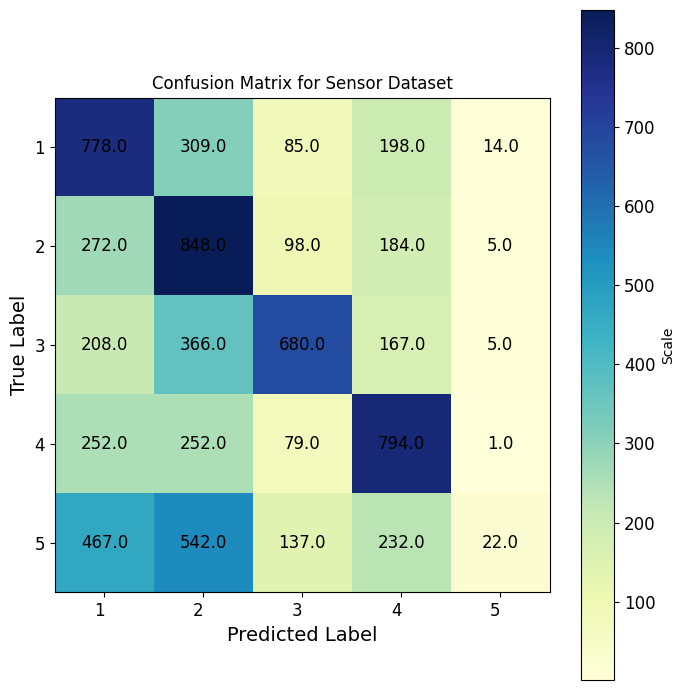

****************************************************************************************************
max_depth=10, criterion=entropy
Accuracy : 0.2
Class wise Precision Values : [0.49660524 0.35592479 0.58259468 0.40248227 0.68055556]
Class wise Recall Values : [0.37074584 0.57894737 0.50772472 0.66132556 0.07127273]
Class wise F1 scores : [0.42454395 0.44083401 0.54258912 0.50041334 0.12903226]
Overall Precision Value : 0.5036325073410192
Overall Recall Value : 0.43800324312055333
Overall F1 score : 0.4074825340985149


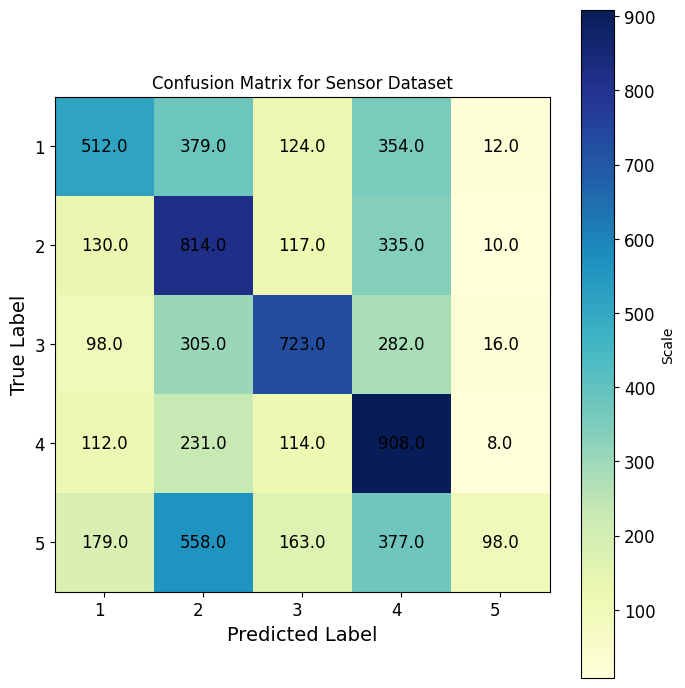

****************************************************************************************************
max_depth=12, criterion=gini
Accuracy : 0.13142857142857142
Class wise Precision Values : [0.33010118 0.41139571 0.52419355 0.51624549 0.59090909]
Class wise Recall Values : [0.56698045 0.56054131 0.45582048 0.52037846 0.02803738]
Class wise F1 scores : [0.41726619 0.47452517 0.48762191 0.51830373 0.05353466]
Overall Precision Value : 0.47456900412764025
Overall Recall Value : 0.42635161531738835
Overall F1 score : 0.39025033187472613


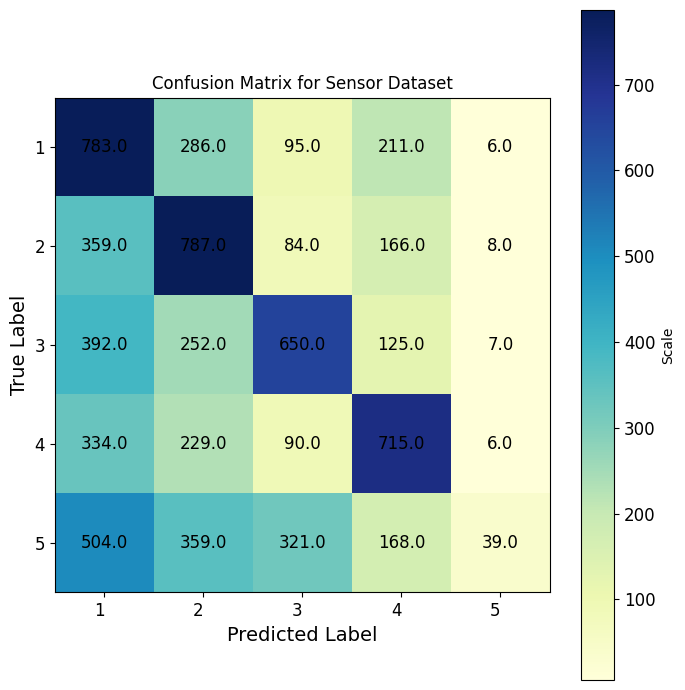

****************************************************************************************************
max_depth=12, criterion=entropy
Accuracy : 0.2357142857142857
Class wise Precision Values : [0.40750257 0.39472267 0.63249516 0.42307692 0.6199262 ]
Class wise Recall Values : [0.57967836 0.52432046 0.46284501 0.54638422 0.12650602]
Class wise F1 scores : [0.47857574 0.45038402 0.53453208 0.47688875 0.21013133]
Overall Precision Value : 0.4955447054193474
Overall Recall Value : 0.4479468154283893
Overall F1 score : 0.4301023846513569


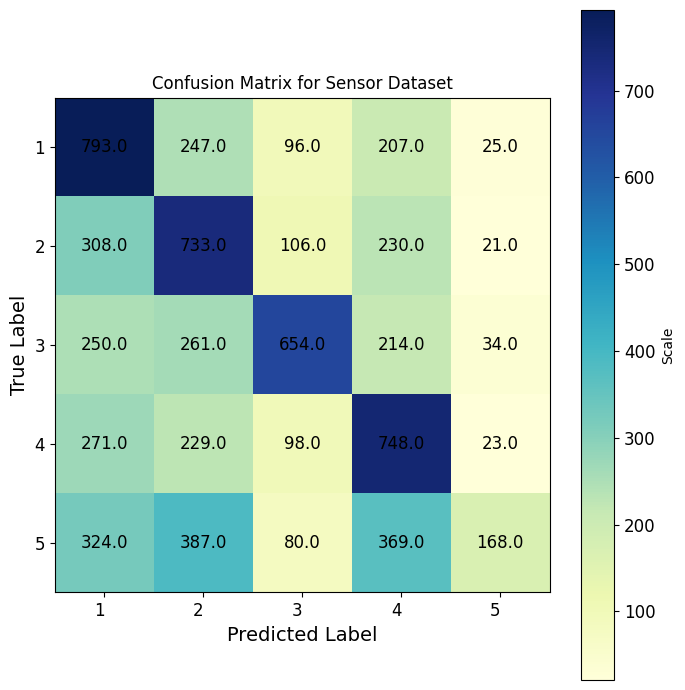

****************************************************************************************************
max_depth=14, criterion=gini
Accuracy : 0.17857142857142858
Class wise Precision Values : [0.43560606 0.39636542 0.47030594 0.51255539 0.66914498]
Class wise Recall Values : [0.50254916 0.57890961 0.55484784 0.50768105 0.13206163]
Class wise F1 scores : [0.46668921 0.47055394 0.50909091 0.51010658 0.22058824]
Overall Precision Value : 0.49679555893211713
Overall Recall Value : 0.4552098597354687
Overall F1 score : 0.4354057741496228


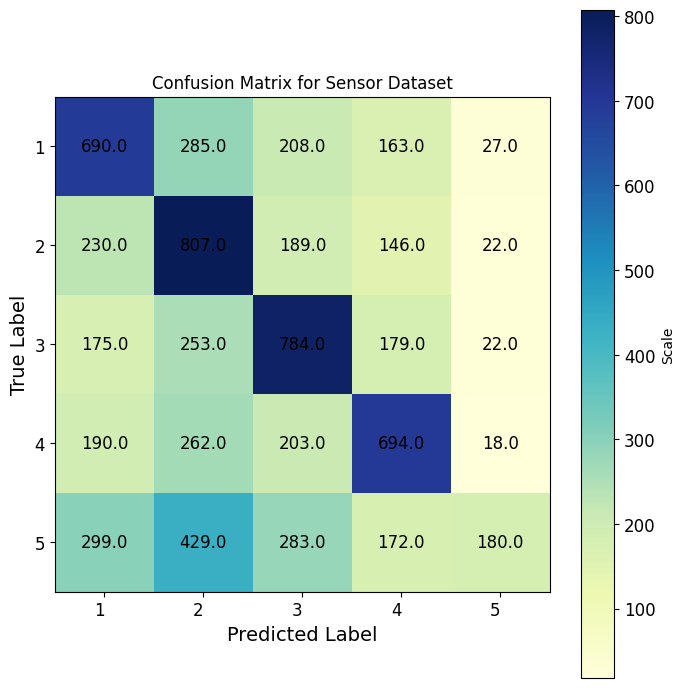

****************************************************************************************************
max_depth=14, criterion=entropy
Accuracy : 0.23714285714285716
Class wise Precision Values : [0.37691522 0.4116553  0.46978558 0.50684932 0.56756757]
Class wise Recall Values : [0.53633721 0.47428571 0.51095406 0.48577681 0.21304348]
Class wise F1 scores : [0.44271146 0.44075672 0.48950575 0.49608939 0.30979979]
Overall Precision Value : 0.4665545955957203
Overall Recall Value : 0.4440794541409582
Overall F1 score : 0.4357726216439929


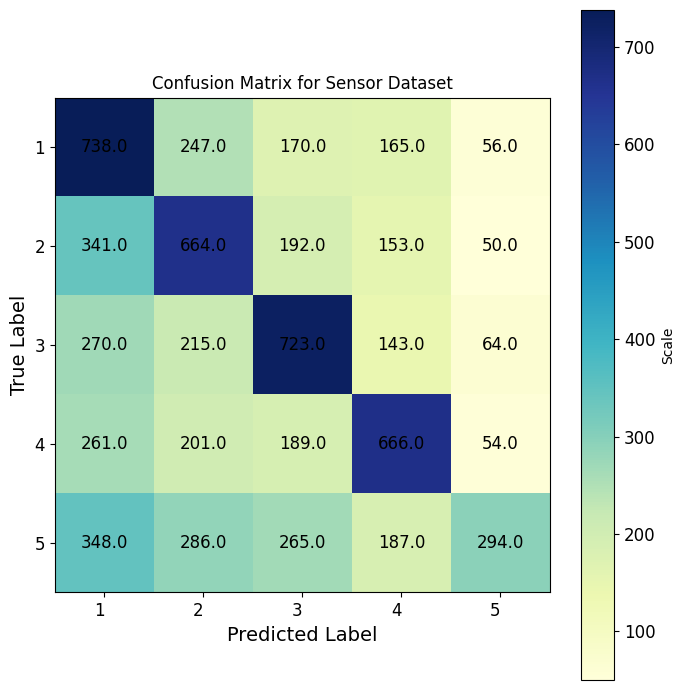

In [ ]:
# Train decision trees with different depths and impurity functions

print("Applying classification trees using Gini impurity and cross-entropy as impurity functions with different depths on Sensor Dataset.\n")

for max_depth in [10 , 12 , 14]:
    for criterion in ['gini', 'entropy']:
        print("*" * 100)
        # Create a DecisionTree object with specified maximum depth and impurity criterion
        tree = DecisionTree(max_depth=max_depth, criterion=criterion)
        
        # Fit the tree to the training data
        tree.fit(xtrain[:7000], ytrain[:7000])
        
        # Make predictions on the test data
        y_pred = tree.predict(xtest[:7000])
        
        accuracy = accuracy_score(np.array(ytest[:7000]), np.array(y_pred))

        # Print the results
        print(f"max_depth={max_depth}, criterion={criterion}")

        confusion_matrix, class_precision, class_recall, class_f1, macro_precision, macro_recall, macro_f1 =  confusion_matrix_precision_recall_f1(np.array(y_pred), np.array(ytest[:7000]))
        print(f"Accuracy : {accuracy}")
        print(f"Class wise Precision Values : {class_precision}")
        print(f"Class wise Recall Values : {class_recall}")
        print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision Value : {macro_precision}")
        print(f"Overall Recall Value : {macro_recall}")
        print(f"Overall F1 score : {macro_f1}")
        plot_confusion_matrix(confusion_matrix , np.unique(ytest), "Sensor Dataset")

**Implementing classification trees using Gini impurity and cross-entropy as impurity functions with different depths for the PCA MNIST Dataset.**

In [ ]:
# Load data from CSV file
Data = np.genfromtxt("/content/drive/MyDrive/p5_PCA_MNIST.csv", delimiter=",", dtype=float)

# Extract X and y from data
xtrain = Data[1:, 1:]
ytrain = Data[1:, 0]

# Shuffle the data randomly
indices = np.arange(xtrain.shape[0])
np.random.shuffle(indices)

# Split the data into 80% training and 20% test data
split_idx = int(0.8 * xtrain.shape[0])
train_indices, test_indices = indices[:split_idx], indices[split_idx:]

# Split X into X_train_pca and X_test_pca using the shuffled indices
X_train_pca, X_test_pca = xtrain[train_indices], xtrain[test_indices]

# Split y into y_train and y_test using the shuffled indices
y_train, y_test = ytrain[train_indices], ytrain[test_indices]

Applying classification trees using Gini impurity and cross-entropy as impurity functions with different depths on PCA MNIST Dataset.

****************************************************************************************************
max_depth=6, criterion=gini
Accuracy : 0.638
Class wise Precision Values : [0.70870337 0.83425414 0.90153173 0.8388521  0.71405229 0.83083512
 0.7462963  0.77874187 0.53012048 0.9704142 ]
Class wise Recall Values : [0.78698225 0.604      0.8442623  0.77868852 0.84526112 0.79835391
 0.82244898 0.71089109 0.77952756 0.64187867]
Class wise F1 scores : [0.74579439 0.70069606 0.87195767 0.80765143 0.7741364  0.81427072
 0.78252427 0.74327122 0.6310757  0.77267373]
Overall Precision Value : 0.7853801594491754
Overall Recall Value : 0.7612294396546524
Overall F1 score : 0.7644051607128505


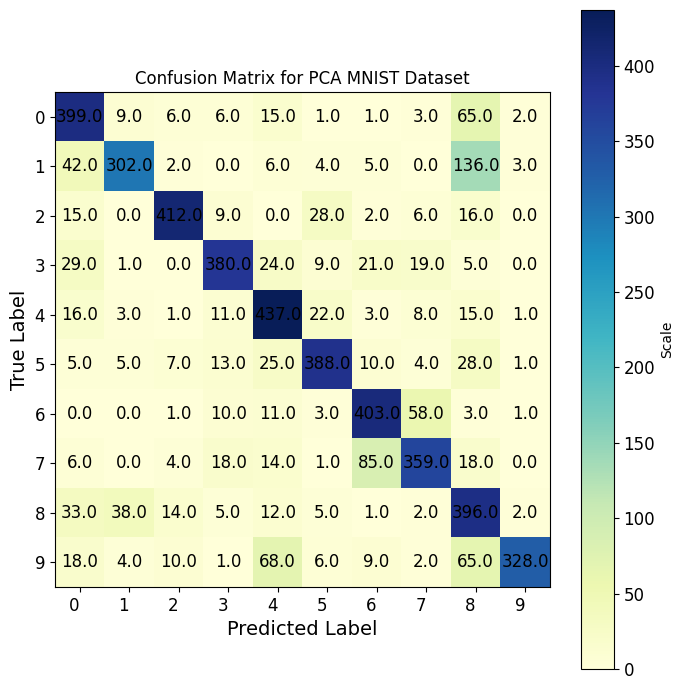

****************************************************************************************************
max_depth=6, criterion=entropy
Accuracy : 0.748
Class wise Precision Values : [0.58403361 0.68670886 0.64883721 0.83840749 0.80337079 0.7872807
 0.77915633 0.65365025 0.73241852 0.88723404]
Class wise Recall Values : [0.54832347 0.868      0.57172131 0.73360656 0.82978723 0.73868313
 0.64081633 0.76237624 0.84055118 0.81604697]
Class wise F1 scores : [0.56561546 0.76678445 0.60784314 0.78251366 0.81636537 0.76220807
 0.70324748 0.70383912 0.7827681  0.85015291]
Overall Precision Value : 0.7401097815560538
Overall Recall Value : 0.7349912413856058
Overall F1 score : 0.7341337758627334


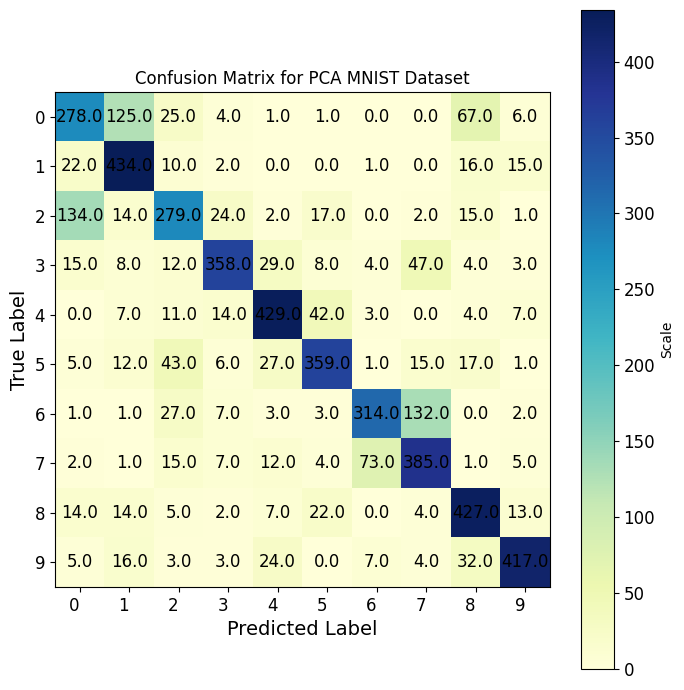

****************************************************************************************************
max_depth=8, criterion=gini
Accuracy : 0.688
Class wise Precision Values : [0.80812641 0.88421053 0.89049587 0.80837004 0.84722222 0.79417879
 0.79861111 0.67864271 0.59612725 0.84691849]
Class wise Recall Values : [0.7061144  0.84       0.88319672 0.75204918 0.82591876 0.78600823
 0.70408163 0.67326733 0.8484252  0.83365949]
Class wise F1 scores : [0.75368421 0.86153846 0.88683128 0.77919321 0.83643487 0.79007239
 0.7483731  0.67594433 0.7002437  0.84023669]
Overall Precision Value : 0.7952903427700584
Overall Recall Value : 0.7852720940032951
Overall F1 score : 0.7872552236982144


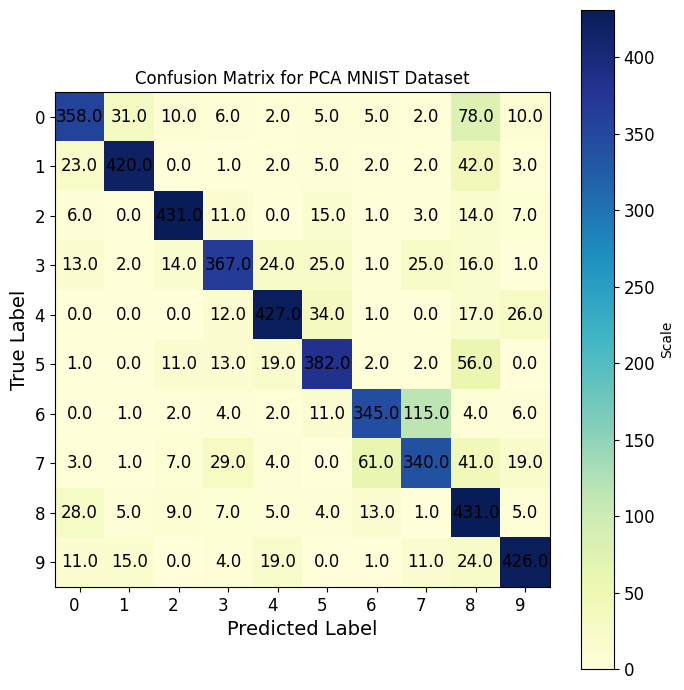

****************************************************************************************************
max_depth=8, criterion=entropy
Accuracy : 0.758
Class wise Precision Values : [0.72486772 0.79120879 0.91368421 0.83552632 0.83520599 0.81818182
 0.68046358 0.82887701 0.75833333 0.91703057]
Class wise Recall Values : [0.81065089 0.864      0.88934426 0.7807377  0.86266925 0.85185185
 0.83877551 0.61386139 0.71653543 0.82191781]
Class wise F1 scores : [0.76536313 0.82600382 0.90134995 0.80720339 0.84871551 0.83467742
 0.75137112 0.70534699 0.73684211 0.86687307]
Overall Precision Value : 0.8103379335608943
Overall Recall Value : 0.8050344089919639
Overall F1 score : 0.8043746489549454


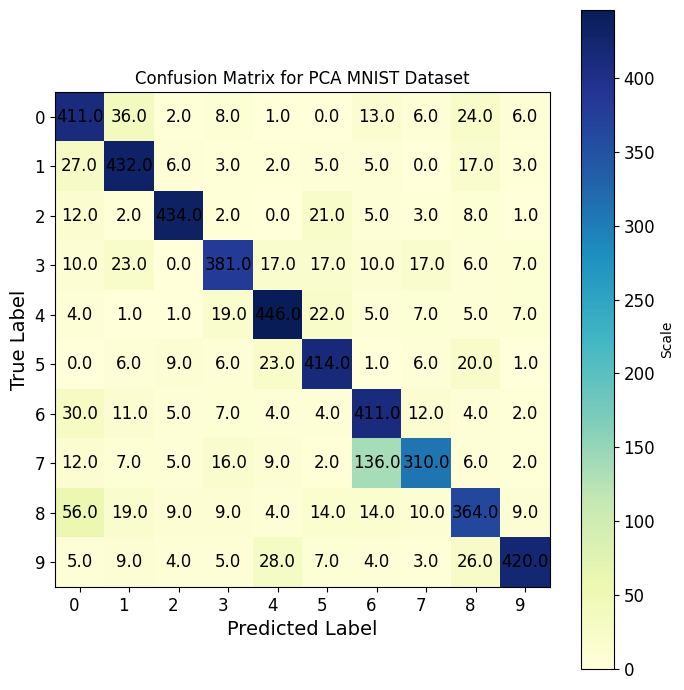

****************************************************************************************************
max_depth=10, criterion=gini
Accuracy : 0.742
Class wise Precision Values : [0.77932406 0.84867076 0.93868922 0.80943026 0.87570621 0.83461538
 0.82083333 0.79049676 0.81836327 0.83239171]
Class wise Recall Values : [0.77317554 0.83       0.90983607 0.8442623  0.89941973 0.89300412
 0.80408163 0.72475248 0.80708661 0.86497065]
Class wise F1 scores : [0.77623762 0.83923155 0.92403746 0.82647944 0.88740458 0.86282306
 0.81237113 0.75619835 0.81268583 0.84836852]
Overall Precision Value : 0.834852096557186
Overall Recall Value : 0.8350589115361728
Overall F1 score : 0.8345837542608574


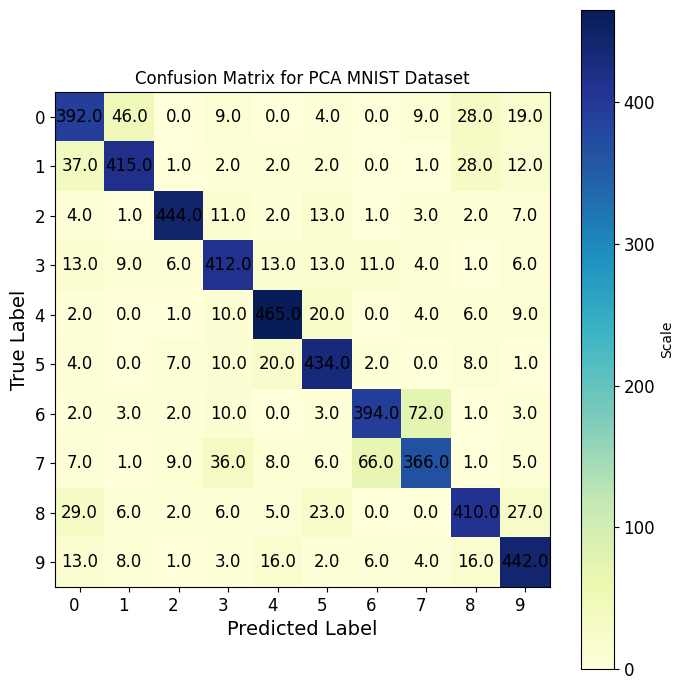

****************************************************************************************************
max_depth=10, criterion=entropy
Accuracy : 0.77
Class wise Precision Values : [0.78071834 0.84703633 0.9168357  0.75294118 0.90059642 0.84615385
 0.83744856 0.80042918 0.88322718 0.84380952]
Class wise Recall Values : [0.81459566 0.886      0.92622951 0.78688525 0.8762089  0.8600823
 0.83061224 0.73861386 0.81889764 0.86692759]
Class wise F1 scores : [0.7972973  0.86608016 0.92150866 0.76953908 0.88823529 0.85306122
 0.83401639 0.76828012 0.84984678 0.85521236]
Overall Precision Value : 0.8409196253499062
Overall Recall Value : 0.8405052953894474
Overall F1 score : 0.8403077369761685


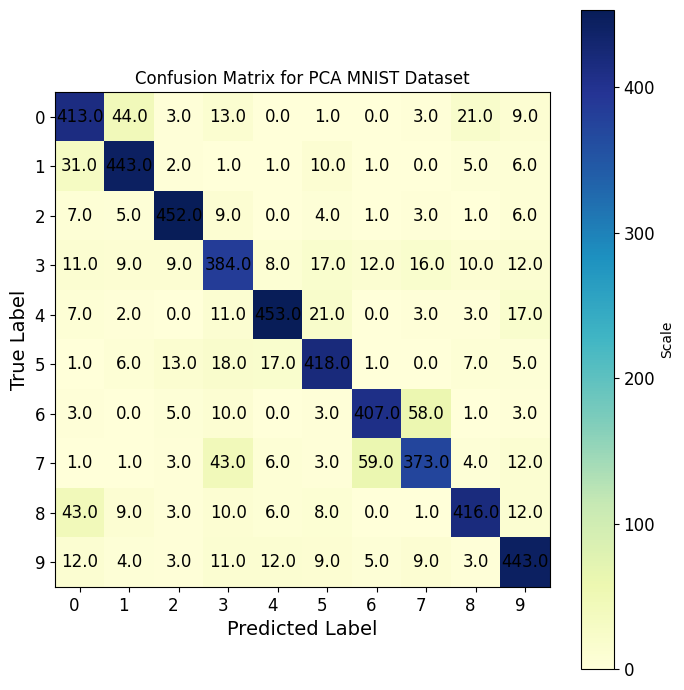

****************************************************************************************************
max_depth=12, criterion=gini
Accuracy : 0.788
Class wise Precision Values : [0.78388998 0.83846154 0.89336016 0.85208333 0.89823875 0.87268994
 0.83125    0.75855513 0.85390947 0.87103175]
Class wise Recall Values : [0.78698225 0.872      0.90983607 0.83811475 0.88781431 0.8744856
 0.81428571 0.79009901 0.81692913 0.8590998 ]
Class wise F1 scores : [0.78543307 0.85490196 0.90152284 0.84504132 0.89299611 0.87358684
 0.82268041 0.77400582 0.83501006 0.86502463]
Overall Precision Value : 0.8453470043198645
Overall Recall Value : 0.8449646640597145
Overall F1 score : 0.8450203073231188


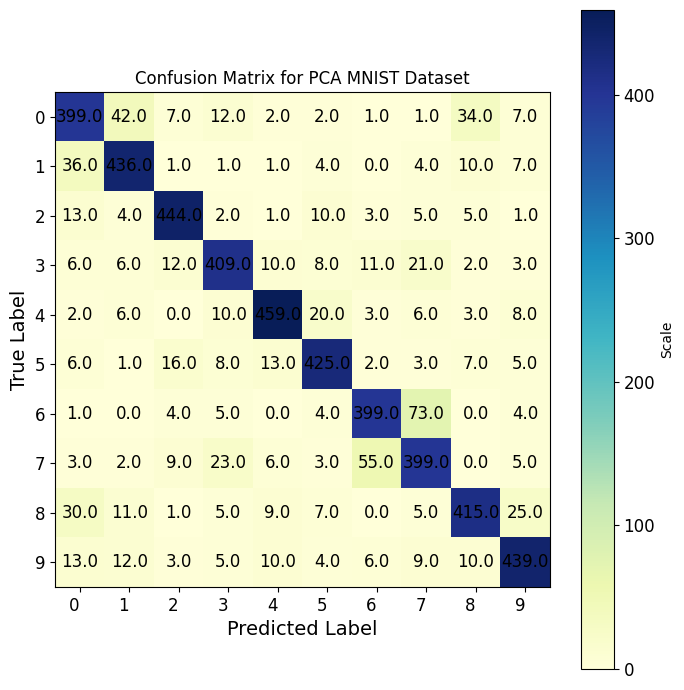

****************************************************************************************************
max_depth=12, criterion=entropy
Accuracy : 0.75
Class wise Precision Values : [0.77798861 0.8389662  0.91532258 0.82377049 0.89855072 0.89352818
 0.76599634 0.78173719 0.81417625 0.84189723]
Class wise Recall Values : [0.8086785  0.844      0.93032787 0.82377049 0.83945841 0.88065844
 0.85510204 0.6950495  0.83661417 0.83365949]
Class wise F1 scores : [0.79303675 0.84147557 0.92276423 0.82377049 0.868      0.88704663
 0.80810029 0.73584906 0.82524272 0.83775811]
Overall Precision Value : 0.8351933814255353
Overall Recall Value : 0.8347318921971327
Overall F1 score : 0.8343043851774443


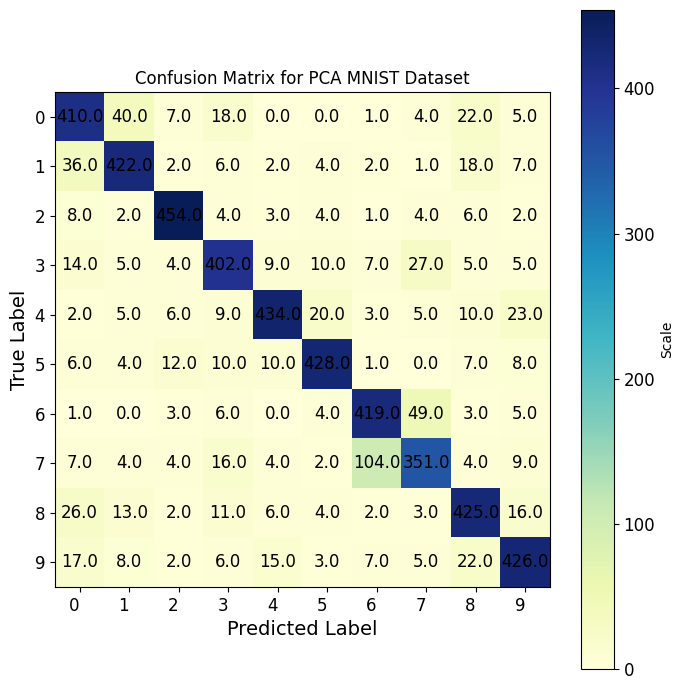

In [ ]:
# Train decision trees with different depths and impurity functions

print("Applying classification trees using Gini impurity and cross-entropy as impurity functions with different depths on PCA MNIST Dataset.\n")

for max_depth in [6 ,8 , 10 , 12]:
    for criterion in ['gini', 'entropy']:
        print("*" * 100)
        # Create a DecisionTree object with specified maximum depth and impurity criterion
        tree = DecisionTree(max_depth=max_depth, criterion=criterion)
        
        # Fit the tree to the training data
        tree.fit(X_train_pca[:5000], y_train[:5000])
        
        # Make predictions on the test data
        y_pred = tree.predict(X_test_pca[:5000])
        
        
        accuracy = accuracy_score(np.array(y_test[:5000]), np.array(y_pred))

        # Print the results
        print(f"max_depth={max_depth}, criterion={criterion}")

        confusion_matrix, class_precision, class_recall, class_f1, macro_precision, macro_recall, macro_f1 =  confusion_matrix_precision_recall_f1(np.array(y_pred), np.array(y_test[:5000]))
        print(f"Accuracy : {accuracy}")
        print(f"Class wise Precision Values : {class_precision}")
        print(f"Class wise Recall Values : {class_recall}")
        print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision Value : {macro_precision}")
        print(f"Overall Recall Value : {macro_recall}")
        print(f"Overall F1 score : {macro_f1}")
        plot_confusion_matrix(confusion_matrix , np.unique(y_test), "PCA MNIST Dataset")

**Problem 2 : Implementing Random forest Algorithm with varying numbers of trees and features and reporting our observations.**

In [ ]:
# Importing Libraries.

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def accuracy_score(y_true, y_pred):
    """
    This function finds the accuracy score by taking y_true and y_pred as arguments. 

    """
    # Reshape y_true and y_pred to have 10 columns
    y_true = y_true.reshape(-1,10)
    y_pred = y_pred.reshape(-1,10)
    
    # Get the index of the maximum value in each row
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Calculate the mean accuracy score
    return np.mean(y_true == y_pred)

In [ ]:
def plot_confusion_matrix(data, labels, classifier):
    
    fig, ax = plt.subplots(figsize=(7,7))
    plt.title("Confusion Matrix for {}".format(classifier))
    
    cmap = plt.get_cmap('YlGnBu')
    im = ax.imshow(data, interpolation='nearest', cmap=cmap)
    
    # Display colorbar
    cbar = ax.figure.colorbar(im, ax=ax, label='Scale')
    cbar.ax.tick_params(labelsize=12)
    
    # Show all ticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    # Set tick labels
    ax.set_xticklabels(labels.astype(int), fontsize=12)
    ax.set_yticklabels(labels.astype(int), fontsize=12)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="black", fontsize=12)
    
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    
    fig.tight_layout()
    plt.show()

In [ ]:
def confusion_matrix_precision_recall_f1(y_pred, y_true):
    '''
    Computes the confusion matrix, precision, recall, and F1 score for multi-class classification.
    
    :param y_pred: np.array or list, predicted labels
    :param y_true: np.array or list, true labels
    :return: tuple, containing the confusion matrix, precision, recall, and F1 score
    '''
    num_classes = len(np.unique(y_true))
    first_label = int(np.min(y_true))

    # initialize confusion matrix with zeros
    confusion_matrix = np.zeros((num_classes + first_label, num_classes + first_label))

    # loop over all samples
    for i in range(len(y_true)):
        # increment count of true-predicted label pair
        confusion_matrix[int(y_true[i]), int(y_pred[i])] += 1

    confusion_matrix = confusion_matrix[first_label:, first_label:]

    # calculate precision, recall, and F1 score for each class
    class_precision = np.zeros(num_classes)
    class_recall = np.zeros(num_classes)
    class_f1 = np.zeros(num_classes)
    for i in range(num_classes):
        class_precision[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[:, i])
        class_recall[i] = confusion_matrix[i, i] / np.sum(confusion_matrix[i, :])
        class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])

    # calculate overall precision, recall, and F1 score
    macro_precision = np.mean(class_precision)
    macro_recall = np.mean(class_recall)
    macro_f1 = np.mean(class_f1)

    return confusion_matrix, class_precision, class_recall, class_f1, macro_precision, macro_recall, macro_f1

In [ ]:
class Normalize:
    """
    A class used to normalize data to ensure it is in the range -1 to 1.
    """
    def __init__(self):
        """
        Initializes the Normalize class.
        """
        pass

    def fit(self, X: np.ndarray):
        """
        Calculates the column-wise maximum and minimum for the given data array X and the difference between the maximum and minimum for each column.
        
        Parameters:
        X (numpy.ndarray): The data array to be normalized.

        """
        self.col_max = np.max(X, axis=0)
        self.col_min = np.min(X, axis=0)
        self.col_range = self.col_max - self.col_min

    def transform(self, X: np.ndarray):
        """
        Normalizes the given data array X to ensure it is in the range -1 to 1.
        
        Parameters:
        X (numpy.ndarray): The data array to be normalized.

        Returns:
        X_norm (numpy.ndarray): The normalized data array.
        
        """
        X_norm = (2 * ((X - self.col_min) / self.col_range)) - 1
        return X_norm

    def inverse_transform(self, X_norm: np.ndarray):
        """
        Transforms the given normalized data array X_norm back to its original range.
        
        Parameters:
        X_norm (numpy.ndarray): The normalized data array to be transformed.

        Returns:
        X (numpy.ndarray): The transformed data array in its original range.
        
        """
        X = (X_norm + 1) / 2 * self.col_range + self.col_min
        return X

In [ ]:
class Node:
    '''
    A helper class which implements a single node in a decision tree.

    Attributes:
    -----------
    feature : int or None
        The index of the feature used for splitting at this node, or None if this is a leaf node.
    threshold : float or None
        The threshold used for splitting at this node, or None if this is a leaf node.
    data_left : array-like or None
        The subset of the training data that is routed to the left child node, or None if this is a leaf node.
    data_right : array-like or None
        The subset of the training data that is routed to the right child node, or None if this is a leaf node.
    gain : float or None
        The information gain achieved by splitting at this node, or None if this is a leaf node.
    value : float or array-like
        The predicted target value(s) for this leaf node, or None if this is not a leaf node.
    '''


    def __init__(self, feature=None, threshold=None, data_left = None, data_right = None, gain = None, value = None):
        '''
        Constructor for Node class.

        Parameters:
        -----------
        feature : int or None
            The index of the feature used for splitting at this node, or None if this is a leaf node.
        threshold : float or None
            The threshold used for splitting at this node, or None if this is a leaf node.
        data_left : array-like or None
            The subset of the training data that is routed to the left child node, or None if this is a leaf node.
        data_right : array-like or None
            The subset of the training data that is routed to the right child node, or None if this is a leaf node.
        gain : float or None
            The information gain achieved by splitting at this node, or None if this is a leaf node.
        value : float or array-like
            The predicted target value(s) for this leaf node, or None if this is not a leaf node.
        '''

        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [ ]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''

    def __init__(self, min_samples_split = 2, max_depth=5 , max_features = 10):
        '''
        Constructor for the DecisionTree class.

        :param min_samples_split: int, optional (default=2)
            The minimum number of samples required to split an internal node.
        :param max_depth: int, optional (default=5)
            The maximum depth of the tree.
        '''
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.root = None

    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.

        :param s: list
            An array of integer values.
        :return: float, entropy value
            The calculated entropy value.
        '''
        
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))

        # Probabilities of each class label
        percentages = counts / len(s)

        # Calculate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.

        :param parent: list
            The parent node.
        :param left_child: list
            The left child of the parent.
        :param right_child: list
            The right child of the parent.
        :return: float, information gain
            The calculated information gain value.
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)

        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

    
    def _best_split(self, X, y, max_features = None):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param max_features: int or None, maximum number of features to consider
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape

        # Select a random subset of features if max_features is specified
        if max_features is not None and max_features < n_cols:
            feature_indices = np.random.choice(n_cols, max_features, replace = False)
        else:
            feature_indices = range(n_cols)

        # For every dataset feature
        for f_idx in feature_indices:
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split

    
    def _build(self, X, y, depth = 0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y , self.max_features)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        targets = list(y)
        max_count = 0
        most_common = None
        for target in set(targets):
            count = targets.count(target)
            if count > max_count:
                max_count = count
                most_common = target
        return Node(
            value=most_common
        )
    
    
    def fit(self, X, y, max_features = None):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param max_features: int or None, maximum number of features to consider
        :return: None
        '''
        # Call a recursive function to build the tree
        if max_features is not None:
            self.root = self._build(X[:, :max_features], y)
        else:
            self.root = self._build(X, y)

        
    
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [ ]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees = 25, min_samples_split = 2, max_depth = 5 , max_features = 10):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        # Will store individually trained decision trees
        self.decision_trees = []
        
    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []
            
        # Build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split = self.min_samples_split,
                    max_depth = self.max_depth,
                    max_features = self.max_features
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue
    
    def predict(self, X):
        '''
        Predicts class labels for new data instances.
        
        :param X: np.array, new instances to predict
        :return: 
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        # Reshape so we can find the most common value
        y = np.swapaxes(a = y, axis1 = 0, axis2 = 1)
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            label_counts = {}
            for label in preds:
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1
            max_count = 0
            max_label = None
            for label, count in label_counts.items():
                if count > max_count:
                    max_count = count
                    max_label = label
            predictions.append(max_label)
        return predictions

**Applying Random Forest on Sensor Dataset with varying number of features and trees.**

In [ ]:
# load the training data and labels
Data = np.genfromtxt("/content/drive/MyDrive/p3_train (1).csv", delimiter=",", dtype = float)
xtrain = Data[:, :-1] # features are in all columns except the last one
ytrain = Data[:,-1] # labels are in the last column

# load the test data and labels
Data = np.genfromtxt("/content/drive/MyDrive/p3_test (1).csv", delimiter=",", dtype = float)
xtest = Data[:, :-1] # features are in all columns except the last one
ytest = Data[:,-1] # labels are in the last column

# normalize the training data
xtrain_scalar = Normalize()
xtrain_scalar.fit(xtrain) # fit the scalar to the training data
xtrain = xtrain_scalar.transform(xtrain) # transform the training data using the scalar

# normalize the test data using the same scalar as for the training data
xtest = xtrain_scalar.transform(xtest)

Applying Random Forest with varying number of Features and Trees on Sensor Dataset.

****************************************************************************************************
Number of trees: 1 , Number of features : 1
Accuracy : 0.3
Class wise Precision Values : [0.29931973 0.38255034 0.68181818 0.5826087  0.41025641]
Class wise Recall Values : [0.65024631 0.32022472 0.06521739 0.34358974 0.57731959]
Class wise F1 scores : [0.40993789 0.34862385 0.11904762 0.43225806 0.47965739]
Overall Precision Value : 0.4713106702376784
Overall Recall Value : 0.39131954940856006
Overall F1 score : 0.357904962510763


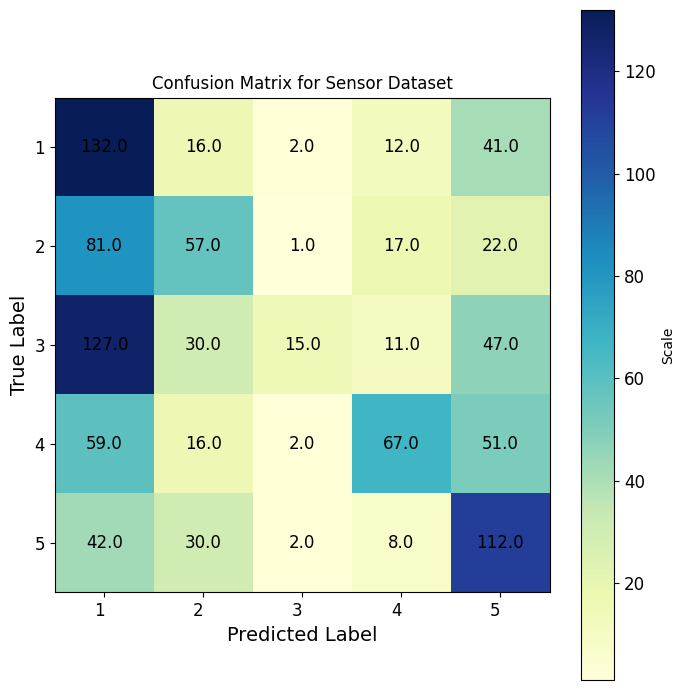

****************************************************************************************************
Number of trees: 1 , Number of features : 3
Accuracy : 0.16
Class wise Precision Values : [0.52352941 0.52830189 0.30602007 0.61206897 0.52380952]
Class wise Recall Values : [0.43842365 0.15730337 0.79565217 0.36410256 0.17010309]
Class wise F1 scores : [0.4772118  0.24242424 0.44202899 0.45659164 0.25680934]
Overall Precision Value : 0.4987459709547112
Overall Recall Value : 0.38511696938116535
Overall F1 score : 0.37501320051418424


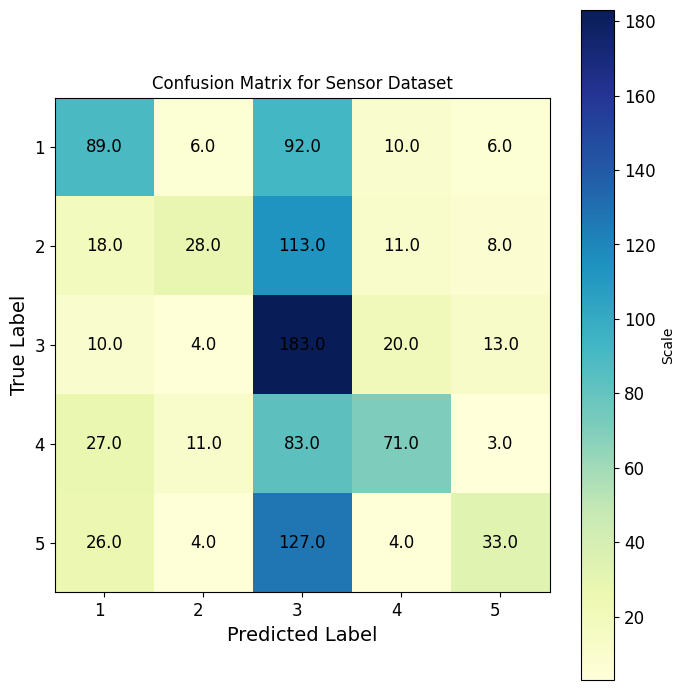

****************************************************************************************************
Number of trees: 1 , Number of features : 5
Accuracy : 0.27
Class wise Precision Values : [0.60330579 0.26333333 0.76153846 0.75903614 0.84848485]
Class wise Recall Values : [0.35960591 0.88764045 0.43043478 0.32307692 0.28865979]
Class wise F1 scores : [0.45061728 0.40616967 0.55       0.45323741 0.43076923]
Overall Precision Value : 0.6471397146117848
Overall Recall Value : 0.4578835720536606
Overall F1 score : 0.45815871812031184


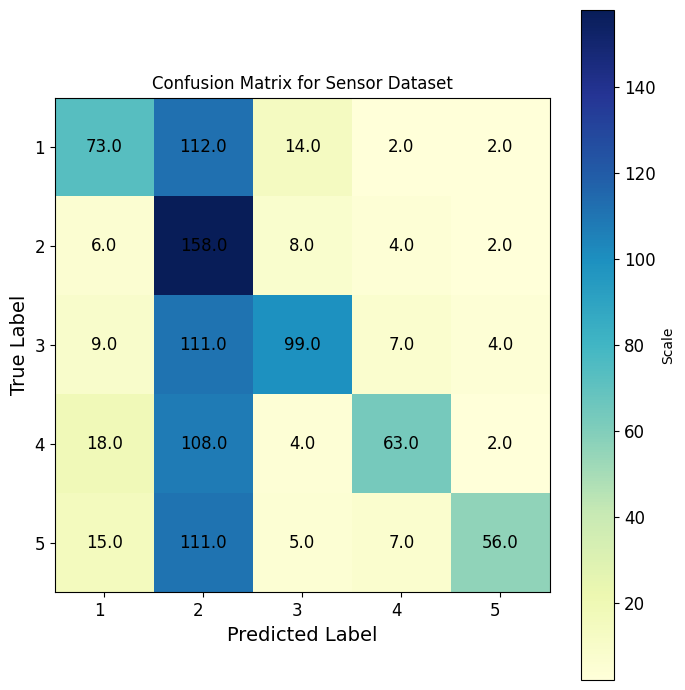

****************************************************************************************************
Number of trees: 1 , Number of features : 7
Accuracy : 0.28
Class wise Precision Values : [0.49751244 0.41463415 0.76315789 0.66666667 0.31263858]
Class wise Recall Values : [0.49261084 0.28651685 0.37826087 0.37948718 0.72680412]
Class wise F1 scores : [0.4950495  0.33887043 0.50581395 0.48366013 0.4372093 ]
Overall Precision Value : 0.5309219452974363
Overall Recall Value : 0.452735972826949
Overall F1 score : 0.4521206646754181


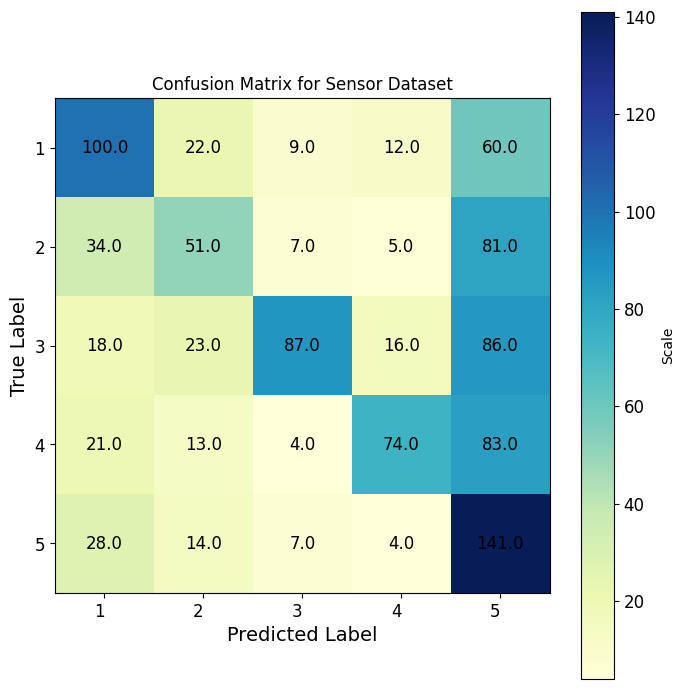

****************************************************************************************************
Number of trees: 1 , Number of features : 10
Accuracy : 0.3
Class wise Precision Values : [0.48108108 0.4625     0.35198556 0.70588235 0.72916667]
Class wise Recall Values : [0.43842365 0.20786517 0.84782609 0.30769231 0.36082474]
Class wise F1 scores : [0.45876289 0.28682171 0.49744898 0.42857143 0.48275862]
Overall Precision Value : 0.5461231320511423
Overall Recall Value : 0.43252639015527866
Overall F1 score : 0.4308727241754431


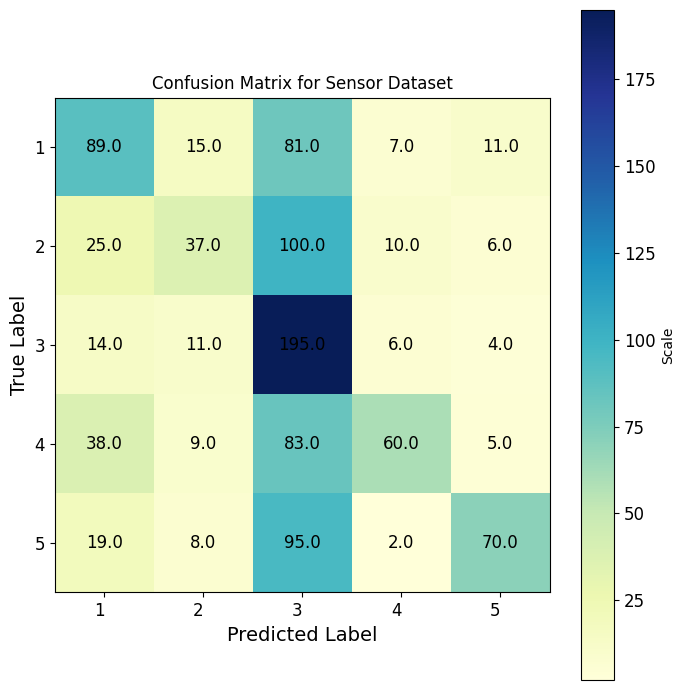

****************************************************************************************************
Number of trees: 5 , Number of features : 1
Accuracy : 0.25
Class wise Precision Values : [0.49479167 0.26269316 0.69230769 0.671875   0.78873239]
Class wise Recall Values : [0.4679803  0.66853933 0.46956522 0.44102564 0.28865979]
Class wise F1 scores : [0.48101266 0.37717908 0.55958549 0.53250774 0.42264151]
Overall Precision Value : 0.5820799820146896
Overall Recall Value : 0.4671540547281154
Overall F1 score : 0.47458529613039174


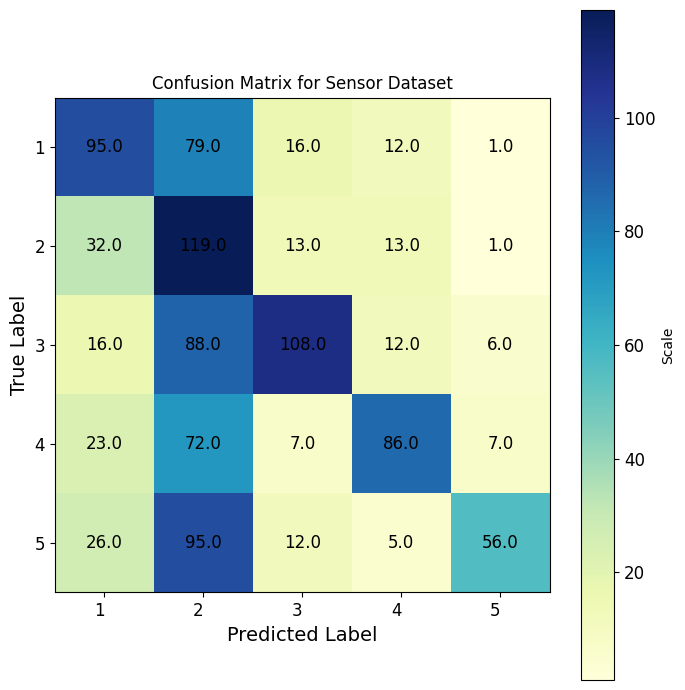

****************************************************************************************************
Number of trees: 5 , Number of features : 3
Accuracy : 0.32
Class wise Precision Values : [0.47963801 0.30909091 0.77372263 0.62406015 0.66935484]
Class wise Recall Values : [0.52216749 0.66853933 0.46086957 0.42564103 0.42783505]
Class wise F1 scores : [0.5        0.42273535 0.57765668 0.50609756 0.52201258]
Overall Precision Value : 0.5711733069927053
Overall Recall Value : 0.5010104911864468
Overall F1 score : 0.5057004323400147


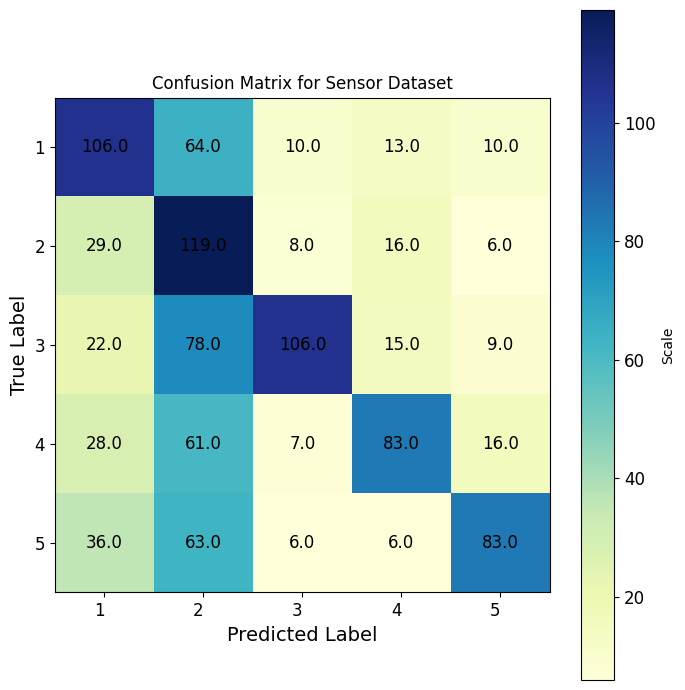

****************************************************************************************************
Number of trees: 5 , Number of features : 5
Accuracy : 0.31
Class wise Precision Values : [0.28787879 0.53691275 0.70967742 0.69354839 0.70909091]
Class wise Recall Values : [0.65517241 0.4494382  0.47826087 0.44102564 0.40206186]
Class wise F1 scores : [0.4        0.48929664 0.57142857 0.53918495 0.51315789]
Overall Precision Value : 0.5874216510198325
Overall Recall Value : 0.4851917964602511
Overall F1 score : 0.5026136110458194


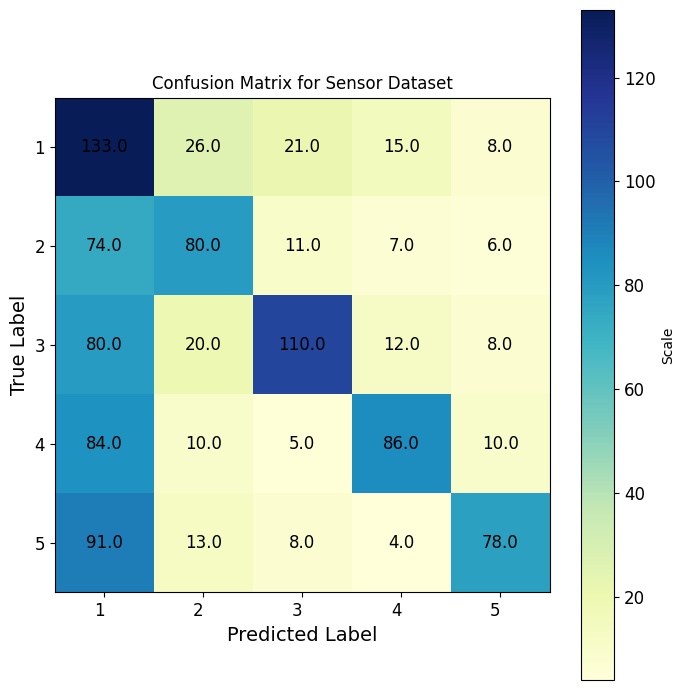

****************************************************************************************************
Number of trees: 5 , Number of features : 7
Accuracy : 0.35
Class wise Precision Values : [0.33746898 0.50588235 0.72297297 0.64754098 0.63694268]
Class wise Recall Values : [0.66995074 0.48314607 0.46521739 0.40512821 0.51546392]
Class wise F1 scores : [0.44884488 0.49425287 0.56613757 0.49842271 0.56980057]
Overall Precision Value : 0.5701615934620431
Overall Recall Value : 0.5077812640580625
Overall F1 score : 0.5154917213847114


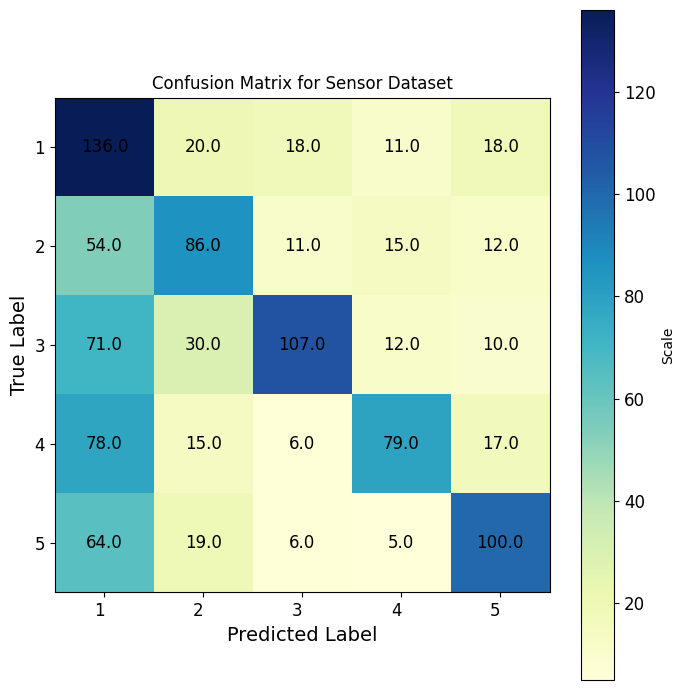

****************************************************************************************************
Number of trees: 5 , Number of features : 10
Accuracy : 0.32
Class wise Precision Values : [0.38855422 0.43096234 0.75       0.7752809  0.55102041]
Class wise Recall Values : [0.63546798 0.57865169 0.46956522 0.35384615 0.55670103]
Class wise F1 scores : [0.48224299 0.4940048  0.57754011 0.48591549 0.55384615]
Overall Precision Value : 0.5791635734006748
Overall Recall Value : 0.5188464135708235
Overall F1 score : 0.5187099081146094


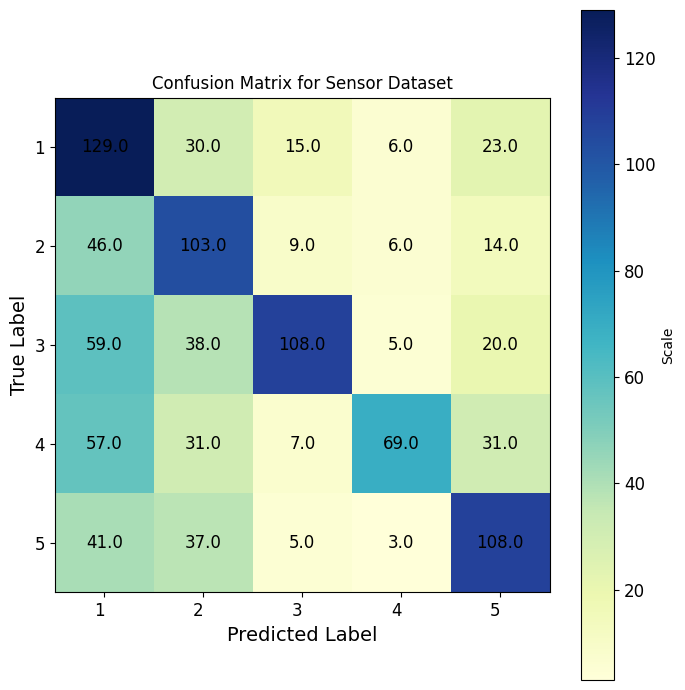

****************************************************************************************************
Number of trees: 10 , Number of features : 1
Accuracy : 0.31
Class wise Precision Values : [0.31961259 0.41463415 0.68131868 0.68656716 0.75700935]
Class wise Recall Values : [0.65024631 0.38202247 0.53913043 0.47179487 0.41752577]
Class wise F1 scores : [0.42857143 0.39766082 0.60194175 0.55927052 0.53820598]
Overall Precision Value : 0.5718283856865346
Overall Recall Value : 0.4921439714204376
Overall F1 score : 0.505130098328293


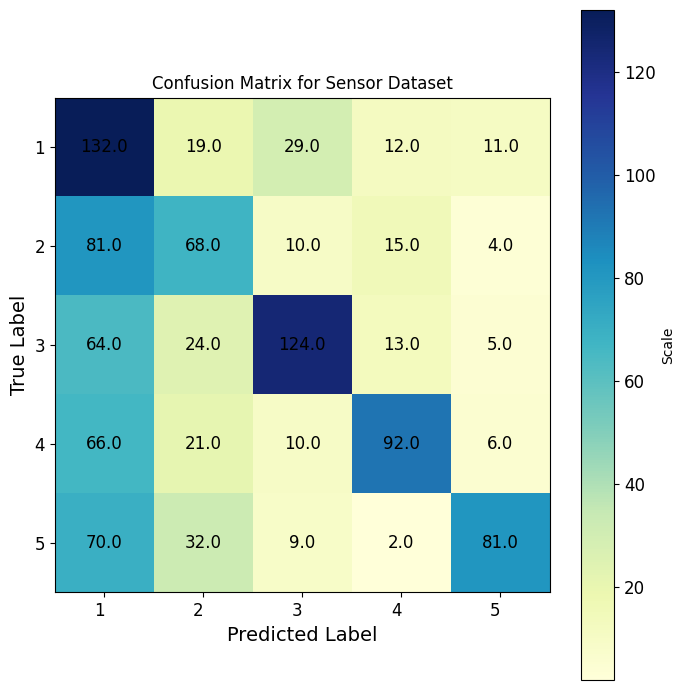

****************************************************************************************************
Number of trees: 10 , Number of features : 3
Accuracy : 0.3
Class wise Precision Values : [0.34331797 0.58646617 0.65625    0.75       0.66666667]
Class wise Recall Values : [0.73399015 0.43820225 0.54782609 0.43076923 0.44329897]
Class wise F1 scores : [0.4678179  0.50160772 0.5971564  0.54723127 0.53250774]
Overall Precision Value : 0.6005401608860861
Overall Recall Value : 0.5188173363544359
Overall F1 score : 0.5292642043663556


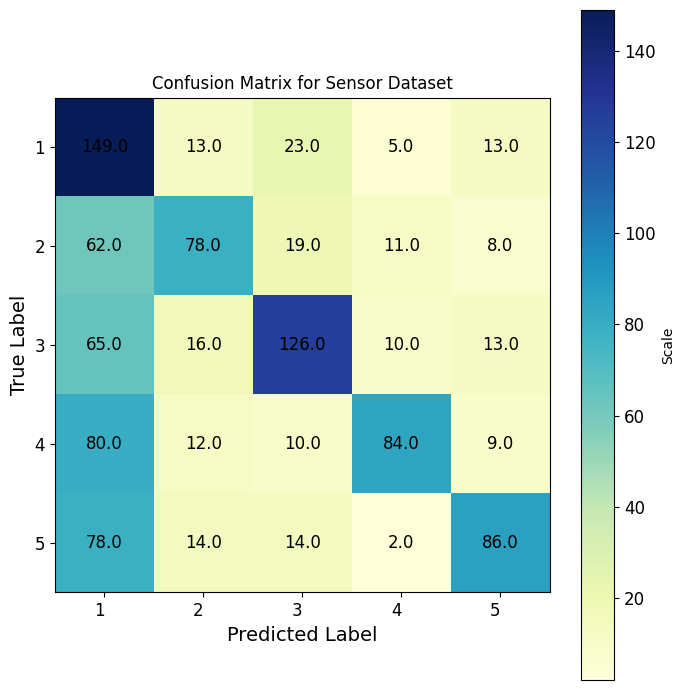

****************************************************************************************************
Number of trees: 10 , Number of features : 5
Accuracy : 0.28
Class wise Precision Values : [0.5        0.45327103 0.75524476 0.75221239 0.41509434]
Class wise Recall Values : [0.52216749 0.54494382 0.46956522 0.43589744 0.68041237]
Class wise F1 scores : [0.51084337 0.49489796 0.57908847 0.55194805 0.515625  ]
Overall Precision Value : 0.5751645024570622
Overall Recall Value : 0.5305972664664418
Overall F1 score : 0.5304805712951135


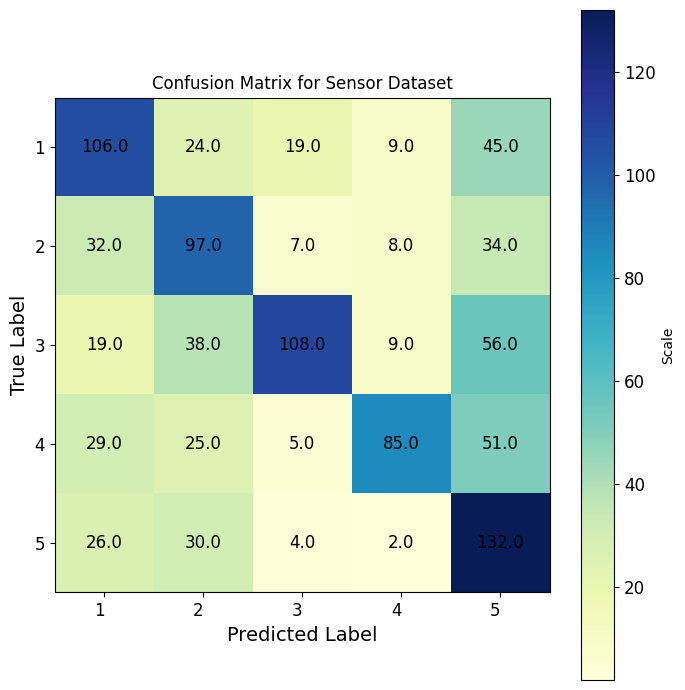

****************************************************************************************************
Number of trees: 10 , Number of features : 7
Accuracy : 0.35
Class wise Precision Values : [0.34170854 0.46082949 0.75       0.76576577 0.70634921]
Class wise Recall Values : [0.66995074 0.56179775 0.4826087  0.43589744 0.45876289]
Class wise F1 scores : [0.45257903 0.50632911 0.58730159 0.55555556 0.55625   ]
Overall Precision Value : 0.6049306015832195
Overall Recall Value : 0.5218035019745587
Overall F1 score : 0.5316030583445914


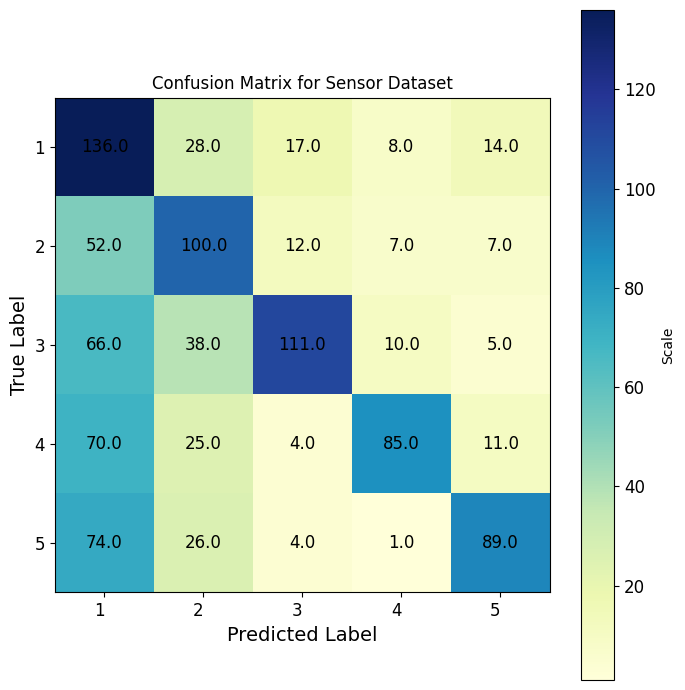

****************************************************************************************************
Number of trees: 10 , Number of features : 10
Accuracy : 0.3
Class wise Precision Values : [0.34183673 0.46330275 0.75167785 0.77142857 0.60294118]
Class wise Recall Values : [0.66009852 0.56741573 0.48695652 0.41538462 0.42268041]
Class wise F1 scores : [0.45042017 0.51010101 0.59102902 0.54       0.4969697 ]
Overall Precision Value : 0.5862374174471217
Overall Recall Value : 0.5105071603998892
Overall F1 score : 0.5177039797769272


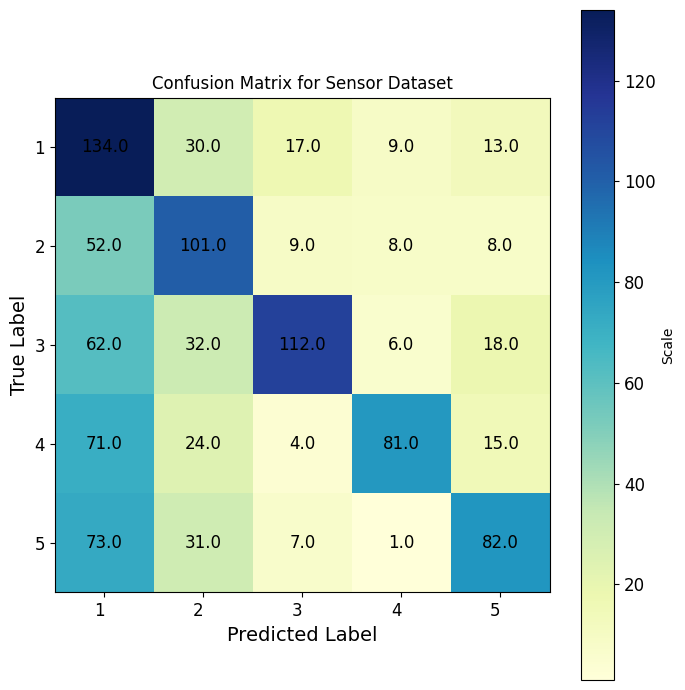

In [ ]:
# List of values to try for the number of trees and number of features
n_trees_values = [1, 5, 10]
n_features_values = [1, 3 , 5 , 7 , 10]

print("Applying Random Forest with varying number of Features and Trees on Sensor Dataset.\n")

# Loop through the different values
for n_trees in n_trees_values:
    for n_features in n_features_values:
        print("*" * 100)
        # Create a random forest classifier with the current number of trees and features
        rf = RandomForest(num_trees = n_trees, max_features = n_features)
        
        # Fit the classifier on the training data
        rf.fit(xtrain[:1000], ytrain[:1000])
        
        # Make predictions on the test data
        y_pred = rf.predict(xtest[:1000])
        
        # Calculate accuracy and print the results
        accuracy = accuracy_score(np.array(ytest[:1000]), np.array(y_pred))
        confusion_matrix, class_precision, class_recall, class_f1, macro_precision, macro_recall, macro_f1 =  confusion_matrix_precision_recall_f1(np.array(y_pred), np.array(ytest[:1000]))
        print(f"Number of trees: {n_trees} , Number of features : {n_features}")
        print(f"Accuracy : {accuracy}")
        print(f"Class wise Precision Values : {class_precision}")
        print(f"Class wise Recall Values : {class_recall}")
        print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision Value : {macro_precision}")
        print(f"Overall Recall Value : {macro_recall}")
        print(f"Overall F1 score : {macro_f1}")
        plot_confusion_matrix(confusion_matrix , np.unique(ytest), "Sensor Dataset")

**Applying Random Forest on PCA MNIST Dataset with varying number of features and trees.**

In [ ]:
Data = np.genfromtxt("/content/drive/MyDrive/p5_PCA_MNIST.csv", delimiter=",", dtype=float)
xtrain = Data[1:, 1:]
ytrain = Data[1:, 0]

indices = np.arange(xtrain.shape[0])
np.random.shuffle(indices)

# Split the data into 80% training and 20% test data
split_idx = int(0.8 * xtrain.shape[0])
train_indices, test_indices = indices[:split_idx], indices[split_idx:]

xtrain, xtest = xtrain[train_indices], xtrain[test_indices]
ytrain, ytest = ytrain[train_indices], ytrain[test_indices]

xtrain_scalar = Normalize()
xtrain_scalar.fit(xtrain)
xtrain = xtrain_scalar.transform(xtrain)

#To keep same reference for normalisation for xtest as well, we are using same xtrain_scalar object for xtest
xtest = xtrain_scalar.transform(xtest)

In [ ]:
# We have 48,000 data points and 10 features in the PCA MNIST training dataset.
# And we have 12000 data points in the test data.

xtrain.shape

(48000, 10)

Applying Random Forest with varying number of Features and Trees on PCA MNIST Dataset.

****************************************************************************************************
Number of trees: 1 , Number of features : 1
Accuracy : 0.56
Class wise Precision Values : [0.72282609 0.69230769 0.68627451 0.5708502  0.76666667 0.85074627
 0.76056338 0.52534562 0.37345679 0.74634146]
Class wise Recall Values : [0.62735849 0.46919431 0.54973822 0.71938776 0.74193548 0.57575758
 0.82233503 0.5786802  0.63020833 0.69545455]
Class wise F1 scores : [0.67171717 0.55932203 0.61046512 0.63656885 0.75409836 0.68674699
 0.7902439  0.55072464 0.46899225 0.72      ]
Overall Precision Value : 0.6695378682760265
Overall Recall Value : 0.6410049945202393
Overall F1 score : 0.6448879307442754


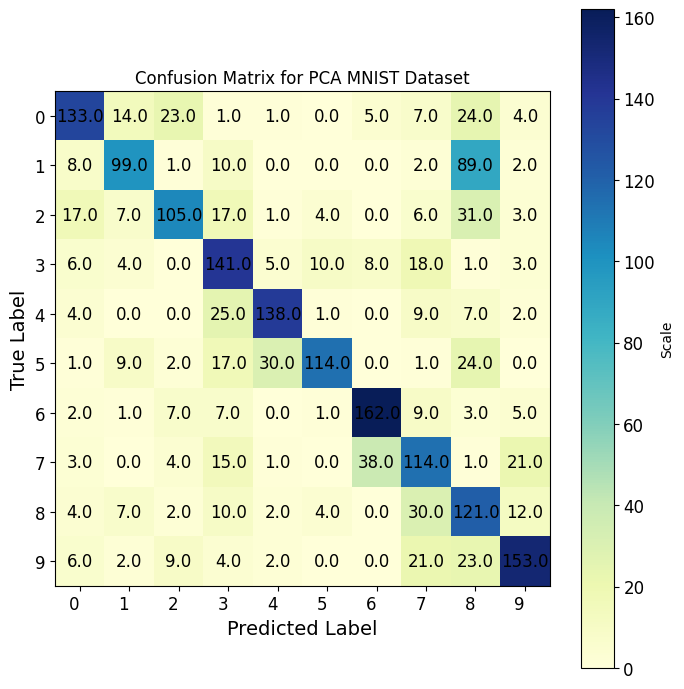

****************************************************************************************************
Number of trees: 1 , Number of features : 3
Accuracy : 0.675
Class wise Precision Values : [0.68609865 0.72105263 0.79591837 0.84864865 0.72368421 0.58196721
 0.76646707 0.69072165 0.703125   0.78695652]
Class wise Recall Values : [0.72169811 0.6492891  0.61256545 0.80102041 0.88709677 0.71717172
 0.64974619 0.68020305 0.703125   0.82272727]
Class wise F1 scores : [0.70344828 0.68329177 0.69230769 0.82414698 0.79710145 0.64253394
 0.7032967  0.68542199 0.703125   0.80444444]
Overall Precision Value : 0.7304639963016054
Overall Recall Value : 0.7244643068594275
Overall F1 score : 0.7239118248923628


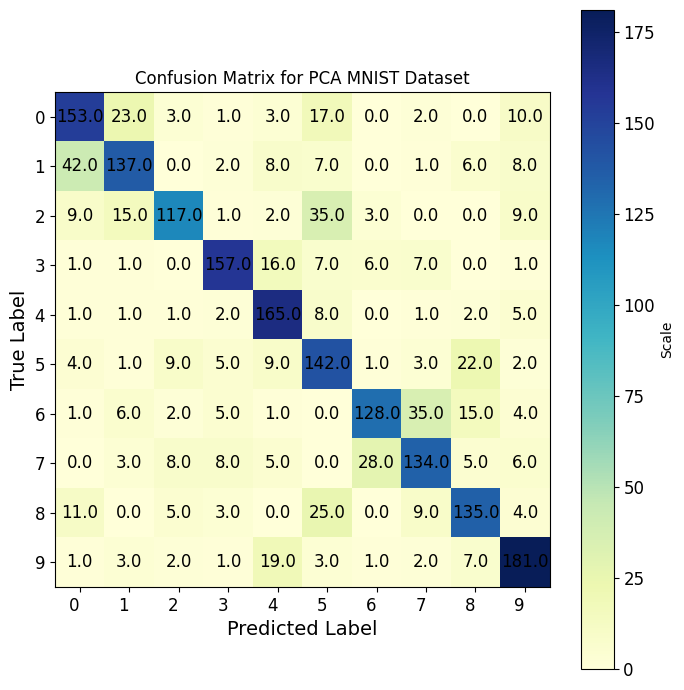

****************************************************************************************************
Number of trees: 1 , Number of features : 5
Accuracy : 0.725
Class wise Precision Values : [0.70750988 0.8245614  0.82323232 0.68240343 0.72769953 0.91946309
 0.76744186 0.86619718 0.7902439  0.80542986]
Class wise Recall Values : [0.84433962 0.66824645 0.85340314 0.81122449 0.83333333 0.69191919
 0.83756345 0.62436548 0.84375    0.80909091]
Class wise F1 scores : [0.76989247 0.7382199  0.83804627 0.74125874 0.77694236 0.78962536
 0.80097087 0.72566372 0.81612091 0.80725624]
Overall Precision Value : 0.7914182469661294
Overall Recall Value : 0.7817236067649901
Overall F1 score : 0.7803996831508063


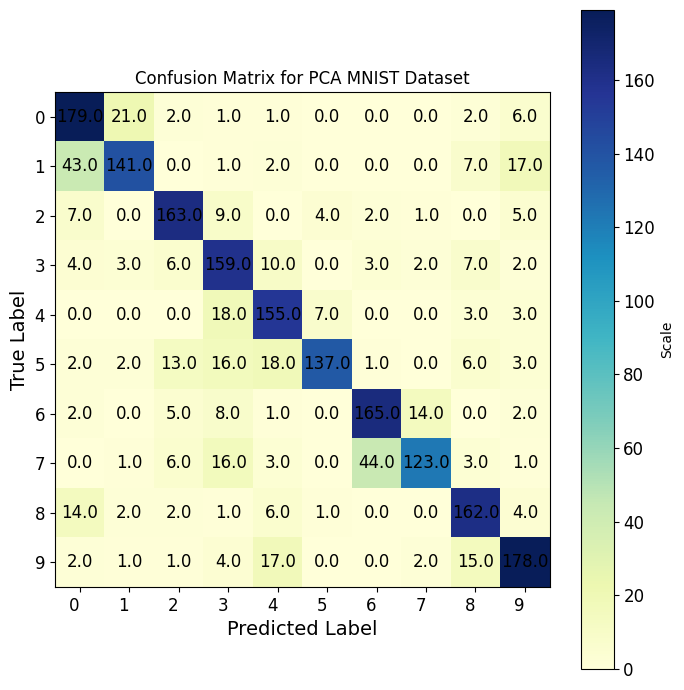

****************************************************************************************************
Number of trees: 1 , Number of features : 7
Accuracy : 0.72
Class wise Precision Values : [0.805      0.73617021 0.85945946 0.7627907  0.71548117 0.87222222
 0.76548673 0.83225806 0.81958763 0.97076023]
Class wise Recall Values : [0.75943396 0.81990521 0.83246073 0.83673469 0.91935484 0.79292929
 0.87817259 0.65482234 0.828125   0.75454545]
Class wise F1 scores : [0.7815534  0.77578475 0.84574468 0.79805353 0.80470588 0.83068783
 0.8179669  0.73295455 0.8238342  0.84910486]
Overall Precision Value : 0.8139216416634127
Overall Recall Value : 0.8076484112438431
Overall F1 score : 0.8060390578047913


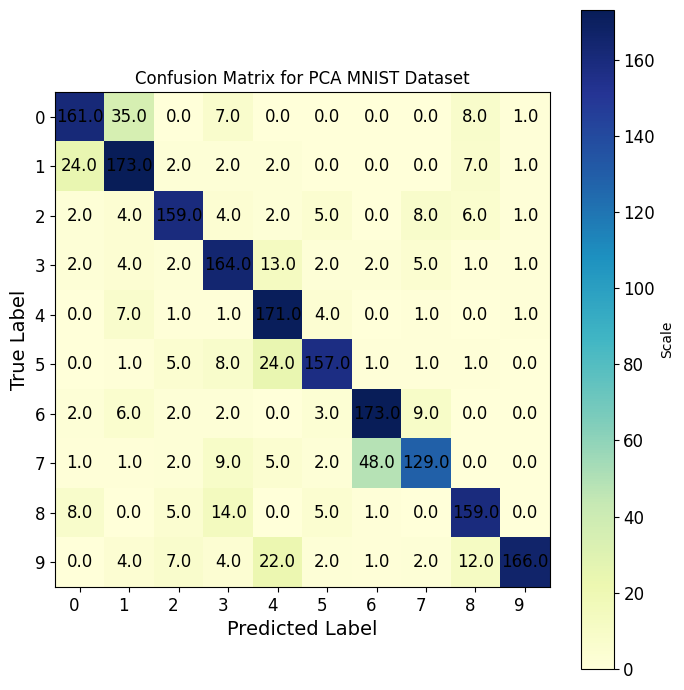

****************************************************************************************************
Number of trees: 1 , Number of features : 10
Accuracy : 0.73
Class wise Precision Values : [0.88832487 0.8436019  0.86432161 0.82539683 0.83928571 0.68333333
 0.78894472 0.68115942 0.78536585 0.91891892]
Class wise Recall Values : [0.8254717  0.8436019  0.90052356 0.79591837 0.75806452 0.82828283
 0.79695431 0.71573604 0.83854167 0.77272727]
Class wise F1 scores : [0.85574572 0.8436019  0.88205128 0.81038961 0.79661017 0.74885845
 0.79292929 0.6980198  0.81108312 0.83950617]
Overall Precision Value : 0.8118653166372519
Overall Recall Value : 0.8075822160539916
Overall F1 score : 0.8078795517601683


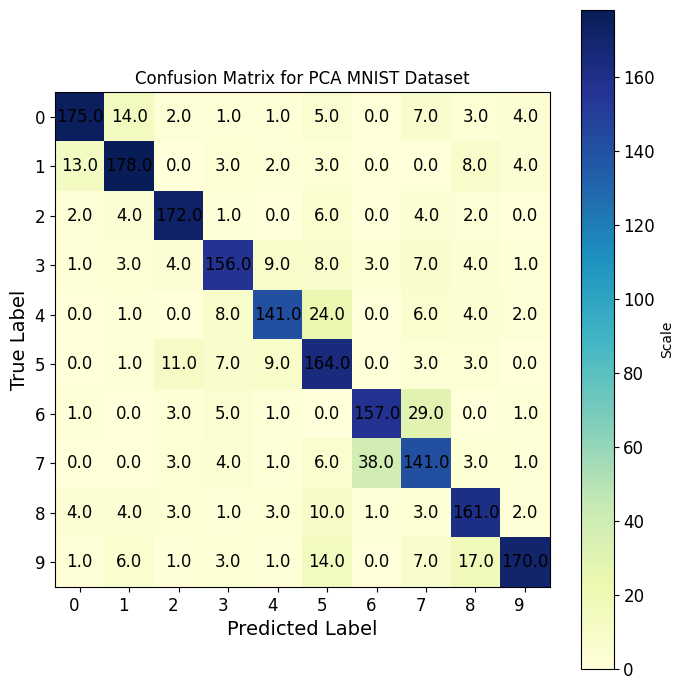

****************************************************************************************************
Number of trees: 5 , Number of features : 1
Accuracy : 0.74
Class wise Precision Values : [0.71836735 0.8226601  0.87150838 0.63052209 0.86885246 0.85945946
 0.67699115 0.69109948 0.83802817 0.90862944]
Class wise Recall Values : [0.83018868 0.79146919 0.81675393 0.80102041 0.85483871 0.8030303
 0.77664975 0.67005076 0.61979167 0.81363636]
Class wise F1 scores : [0.7702407  0.80676329 0.84324324 0.70561798 0.86178862 0.83028721
 0.72340426 0.68041237 0.71257485 0.85851319]
Overall Precision Value : 0.7886118069699195
Overall Recall Value : 0.7777429759047881
Overall F1 score : 0.7792845696367815


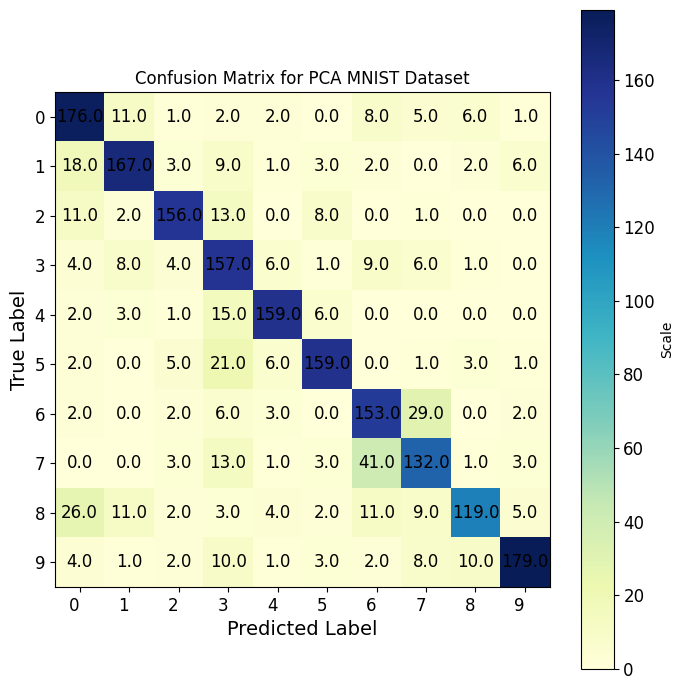

****************************************************************************************************
Number of trees: 5 , Number of features : 3
Accuracy : 0.77
Class wise Precision Values : [0.75396825 0.9119171  0.91578947 0.74885845 0.83333333 0.8956044
 0.81       0.73604061 0.86309524 0.92039801]
Class wise Recall Values : [0.89622642 0.83412322 0.91099476 0.83673469 0.88709677 0.82323232
 0.82233503 0.73604061 0.75520833 0.84090909]
Class wise F1 scores : [0.81896552 0.87128713 0.91338583 0.79036145 0.859375   0.85789474
 0.81612091 0.73604061 0.80555556 0.87885986]
Overall Precision Value : 0.8389004859706917
Overall Recall Value : 0.8342901252304674
Overall F1 score : 0.8347846584326947


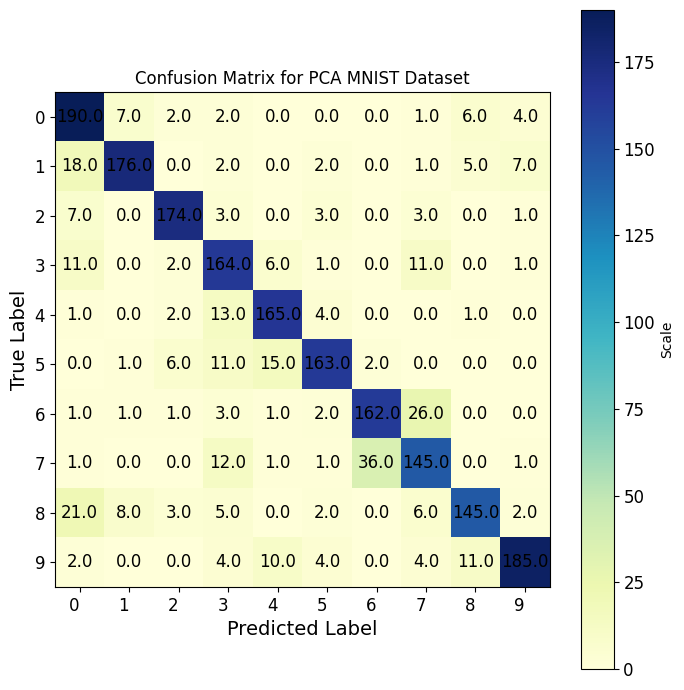

****************************************************************************************************
Number of trees: 5 , Number of features : 5
Accuracy : 0.75
Class wise Precision Values : [0.80275229 0.89393939 0.87434555 0.84236453 0.88235294 0.77826087
 0.83251232 0.83068783 0.77948718 0.93548387]
Class wise Recall Values : [0.8254717  0.83886256 0.87434555 0.87244898 0.88709677 0.9040404
 0.85786802 0.79695431 0.79166667 0.79090909]
Class wise F1 scores : [0.81395349 0.86552567 0.87434555 0.85714286 0.8847185  0.8364486
 0.845      0.8134715  0.78552972 0.85714286]
Overall Precision Value : 0.8452186776430676
Overall Recall Value : 0.843966405752006
Overall F1 score : 0.8433278739910971


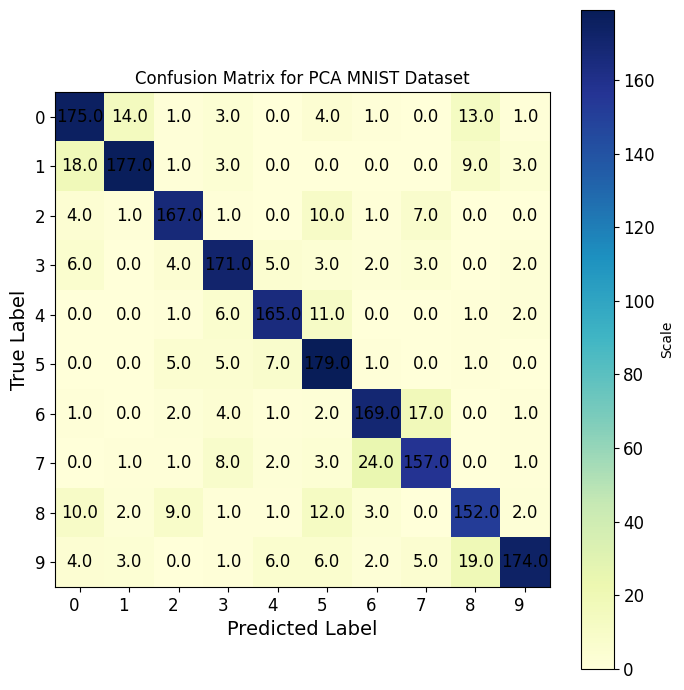

****************************************************************************************************
Number of trees: 5 , Number of features : 7
Accuracy : 0.805
Class wise Precision Values : [0.77459016 0.84615385 0.90104167 0.82439024 0.83417085 0.90526316
 0.78026906 0.86144578 0.88108108 0.97340426]
Class wise Recall Values : [0.89150943 0.83412322 0.90575916 0.8622449  0.89247312 0.86868687
 0.88324873 0.72588832 0.84895833 0.83181818]
Class wise F1 scores : [0.82894737 0.84009547 0.90339426 0.84289277 0.86233766 0.88659794
 0.82857143 0.78787879 0.86472149 0.89705882]
Overall Precision Value : 0.8581810110652196
Overall Recall Value : 0.8544710274929445
Overall F1 score : 0.8542495983642082


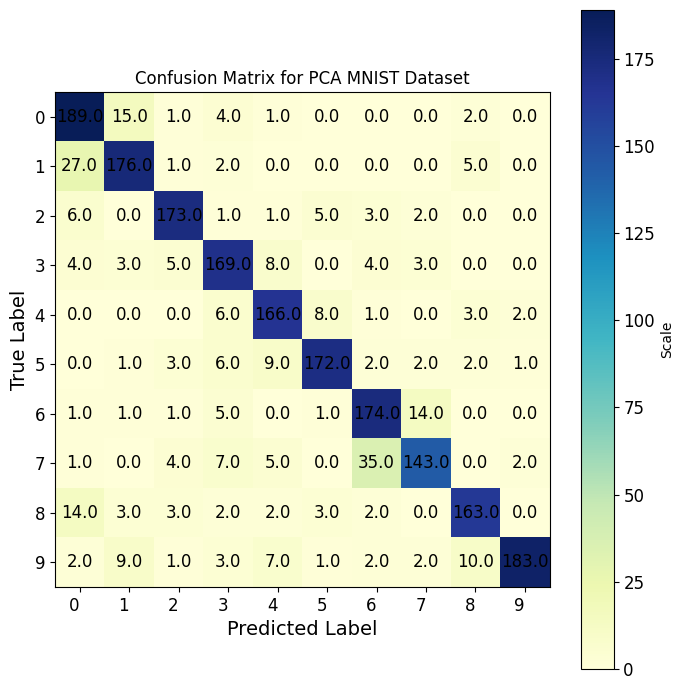

****************************************************************************************************
Number of trees: 5 , Number of features : 10
Accuracy : 0.76
Class wise Precision Values : [0.89268293 0.85981308 0.83663366 0.80092593 0.9132948  0.77876106
 0.7962963  0.78531073 0.86170213 0.93989071]
Class wise Recall Values : [0.86320755 0.87203791 0.88481675 0.88265306 0.84946237 0.88888889
 0.87309645 0.70558376 0.84375    0.78181818]
Class wise F1 scores : [0.87769784 0.86588235 0.86005089 0.83980583 0.88022284 0.83018868
 0.83292978 0.74331551 0.85263158 0.85359801]
Overall Precision Value : 0.8465311328670106
Overall Recall Value : 0.8445314916357101
Overall F1 score : 0.8436323314906087


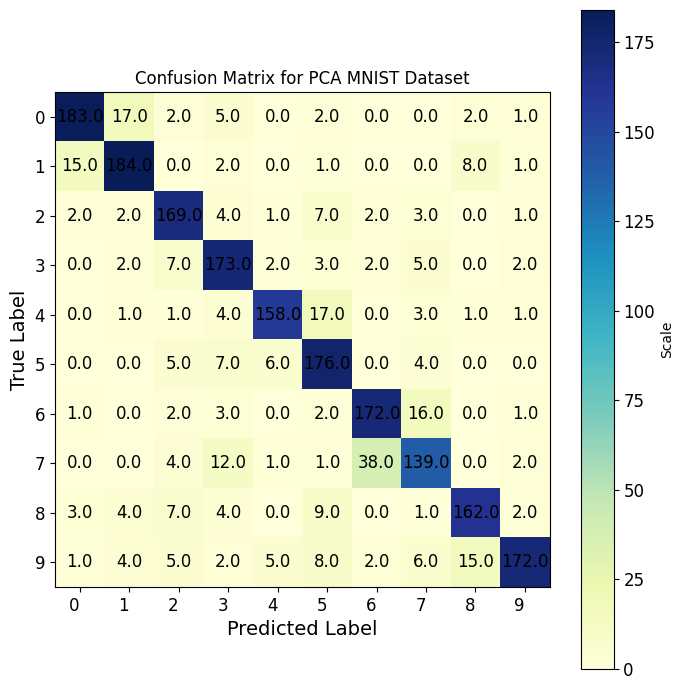

****************************************************************************************************
Number of trees: 10 , Number of features : 1
Accuracy : 0.785
Class wise Precision Values : [0.80172414 0.86111111 0.85416667 0.81481481 0.82673267 0.82488479
 0.74774775 0.82424242 0.82822086 0.92574257]
Class wise Recall Values : [0.87735849 0.88151659 0.85863874 0.78571429 0.89784946 0.9040404
 0.84263959 0.69035533 0.703125   0.85      ]
Class wise F1 scores : [0.83783784 0.87119438 0.85639687 0.8        0.86082474 0.8626506
 0.79236277 0.75138122 0.76056338 0.88625592]
Overall Precision Value : 0.8309387801560986
Overall Recall Value : 0.8291237897677408
Overall F1 score : 0.8279467717165689


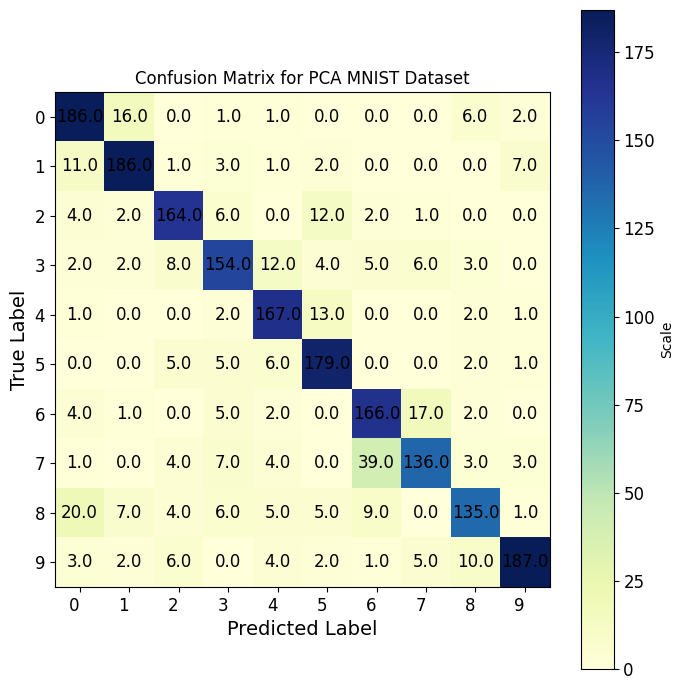

****************************************************************************************************
Number of trees: 10 , Number of features : 3
Accuracy : 0.815
Class wise Precision Values : [0.8173913  0.88292683 0.89285714 0.82692308 0.81603774 0.92222222
 0.85106383 0.80612245 0.835      0.96756757]
Class wise Recall Values : [0.88679245 0.85781991 0.91623037 0.87755102 0.93010753 0.83838384
 0.81218274 0.80203046 0.86979167 0.81363636]
Class wise F1 scores : [0.85067873 0.87019231 0.90439276 0.85148515 0.86934673 0.87830688
 0.83116883 0.80407125 0.85204082 0.88395062]
Overall Precision Value : 0.8618112157802011
Overall Recall Value : 0.8604526338481902
Overall F1 score : 0.8595634077670585


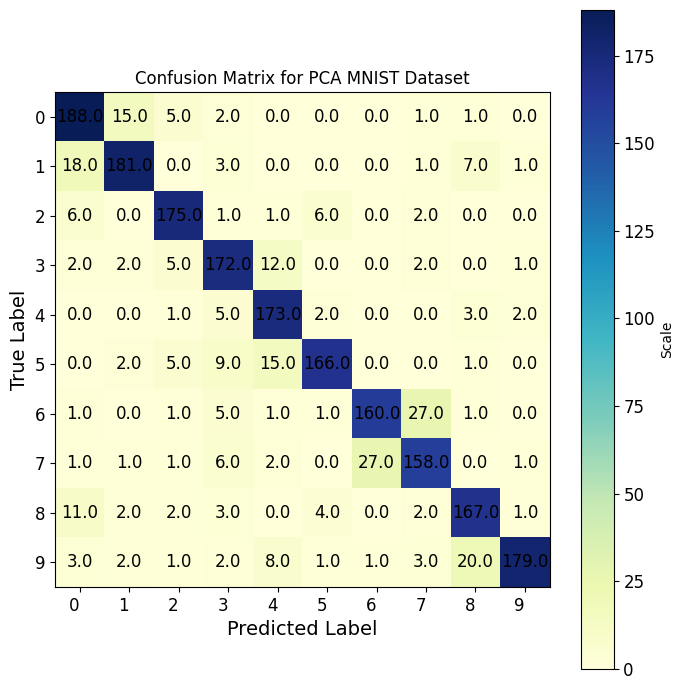

****************************************************************************************************
Number of trees: 10 , Number of features : 5
Accuracy : 0.81
Class wise Precision Values : [0.86320755 0.84931507 0.95027624 0.84183673 0.85858586 0.85645933
 0.80392157 0.80978261 0.82464455 0.97311828]
Class wise Recall Values : [0.86320755 0.88151659 0.90052356 0.84183673 0.91397849 0.9040404
 0.83248731 0.75634518 0.90625    0.82272727]
Class wise F1 scores : [0.86320755 0.86511628 0.92473118 0.84183673 0.88541667 0.87960688
 0.81795511 0.78215223 0.86352357 0.89162562]
Overall Precision Value : 0.863114778883619
Overall Recall Value : 0.8622913088451816
Overall F1 score : 0.8615171822157821


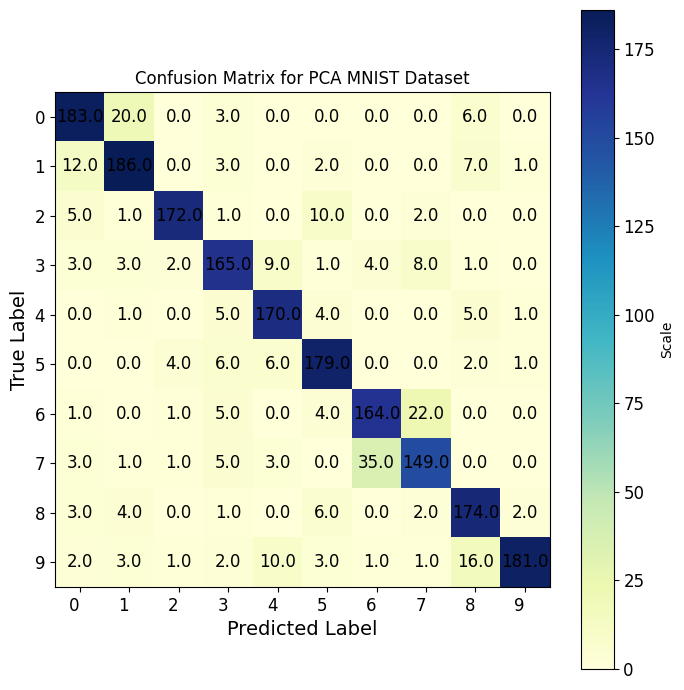

****************************************************************************************************
Number of trees: 10 , Number of features : 7
Accuracy : 0.82
Class wise Precision Values : [0.86915888 0.86320755 0.93650794 0.79439252 0.88770053 0.89340102
 0.82758621 0.81564246 0.7972973  0.96721311]
Class wise Recall Values : [0.87735849 0.86729858 0.92670157 0.86734694 0.89247312 0.88888889
 0.85279188 0.74111675 0.921875   0.80454545]
Class wise F1 scores : [0.87323944 0.86524823 0.93157895 0.82926829 0.89008043 0.89113924
 0.84       0.77659574 0.85507246 0.87841191]
Overall Precision Value : 0.8652107512583198
Overall Recall Value : 0.8640396669376766
Overall F1 score : 0.8630634692201117


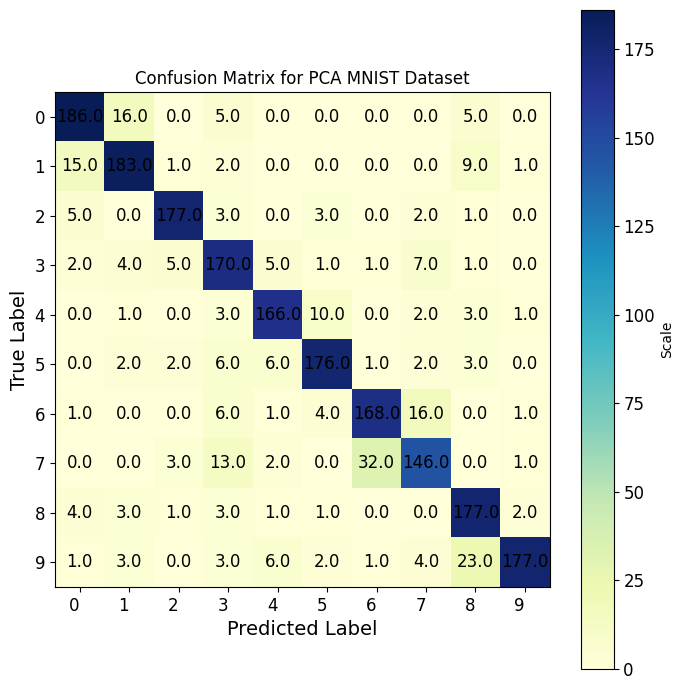

****************************************************************************************************
Number of trees: 10 , Number of features : 10
Accuracy : 0.78
Class wise Precision Values : [0.90338164 0.86915888 0.88832487 0.84079602 0.81773399 0.855
 0.82159624 0.9047619  0.81860465 0.93406593]
Class wise Recall Values : [0.88207547 0.88151659 0.91623037 0.8622449  0.89247312 0.86363636
 0.88832487 0.7715736  0.91666667 0.77272727]
Class wise F1 scores : [0.89260143 0.87529412 0.90206186 0.85138539 0.85347044 0.85929648
 0.85365854 0.83287671 0.86486486 0.84577114]
Overall Precision Value : 0.8653424138283562
Overall Recall Value : 0.8647469222294403
Overall F1 score : 0.863128097321394


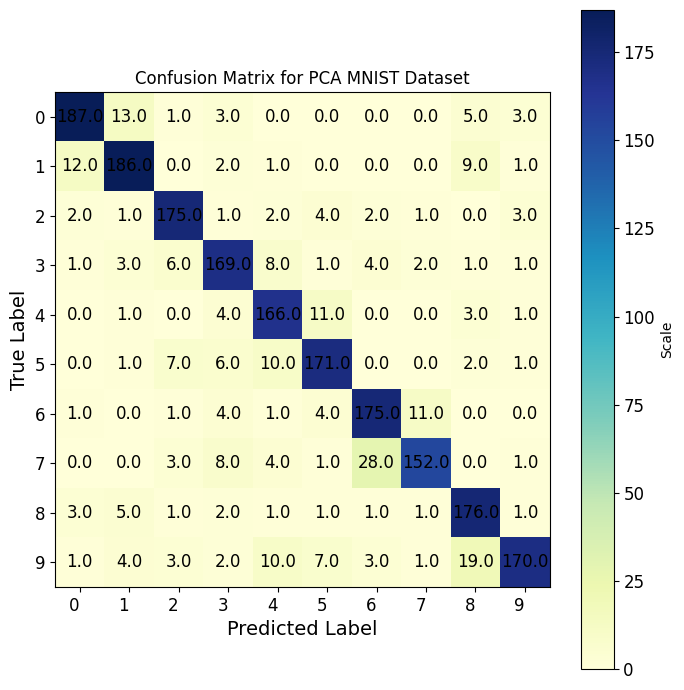

In [ ]:
# List of values to try for the number of trees and number of features
n_trees_values = [1, 5, 10]
n_features_values = [1, 3 , 5 , 7 , 10]

print("Applying Random Forest with varying number of Features and Trees on PCA MNIST Dataset.\n")

# Loop through the different values
for n_trees in n_trees_values:
    for n_features in n_features_values:
        print("*" * 100)
        # Create a random forest classifier with the current number of trees and features
        rf = RandomForest(num_trees = n_trees, max_features = n_features)
        
        # Fit the classifier on the training data
        rf.fit(xtrain[:2000], ytrain[:2000])
        
        # Make predictions on the test data
        y_pred = rf.predict(xtest[:2000])
        
        # Calculate accuracy and print the results
        accuracy = accuracy_score(np.array(ytest[:2000]), np.array(y_pred))
        confusion_matrix, class_precision, class_recall, class_f1, macro_precision, macro_recall, macro_f1 =  confusion_matrix_precision_recall_f1(np.array(y_pred), np.array(ytest[:2000]))
        print(f"Number of trees: {n_trees} , Number of features : {n_features}")
        print(f"Accuracy : {accuracy}")
        print(f"Class wise Precision Values : {class_precision}")
        print(f"Class wise Recall Values : {class_recall}")
        print(f"Class wise F1 scores : {class_f1}")
        print(f"Overall Precision Value : {macro_precision}")
        print(f"Overall Recall Value : {macro_recall}")
        print(f"Overall F1 score : {macro_f1}")
        plot_confusion_matrix(confusion_matrix , np.unique(ytest), "PCA MNIST Dataset")

# Question 3: Adaboost Algorithm

In [ ]:
from copy import deepcopy

In [ ]:
data_set=np.genfromtxt(r"/content/drive/MyDrive/PRNN/A1/PCA_MNIST.csv",delimiter=",",dtype=float,skip_header=1).astype(np.float64)

In [ ]:
X_train=data_set[:int(0.02*(data_set.shape[0])),1:data_set.shape[1]+1]
y_train=data_set[:int(0.02*(data_set.shape[0])),:1]
y_train=y_train.reshape(-1)

In [ ]:
X_test=data_set[int(0.95*(data_set.shape[0])):,1:data_set.shape[1]+1]
y_test=data_set[int(0.95*(data_set.shape[0])):,:1]
y_test=y_test.reshape(-1)

In [ ]:
num_classes=int(len(np.unique(y_train)))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1200, 10)
(1200,)
(3000, 10)
(3000,)


In [ ]:
class DecisionStump:
    def __init__(self):
        self.threshold = None
        self.feature = None
        self.polarity = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            true_indices = np.where(X[:, self.feature] < self.threshold)
            predictions[true_indices] = -1
        else:
            false_indices = np.where(X[:, self.feature] >= self.threshold)
            predictions[false_indices] = -1
        return predictions

In [ ]:
def adaboost(X, y, M, base_learner):
    n_samples, n_features = X.shape
    weights = np.full(n_samples, (1 / n_samples))
    models = []
    alphas = []

    for _ in range(M):
        model = base_learner()

        # Find the best stump using weighted error
        min_error = float('inf')
        for feature in range(n_features):
            for threshold in X[:, feature]:
                for polarity in [1, -1]:
                    model.threshold = threshold
                    model.feature = feature
                    model.polarity = polarity
                    predictions = model.predict(X)
                    error = sum(weights * (y != predictions))

                    if error < min_error:
                        min_error = error
                        best_stump = deepcopy(model)

        model = best_stump

        # Compute alpha (importance) of the current model
        alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-10))
        alphas.append(alpha)

        # Update the weights
        predictions = model.predict(X)
        weights *= np.exp(-alpha * y * predictions)
        weights /= np.sum(weights)

        models.append(model)

    return models, np.array(alphas)

def adaboost_ova(X, y, M, base_learner):
    n_classes = len(np.unique(y))
    binary_classifiers = []

    for cls in range(n_classes):
        binary_y = np.where(y == cls, 1, -1)
        models, alphas = adaboost(X, binary_y, M, base_learner)
        binary_classifiers.append((models, alphas))

    return binary_classifiers

def predict_ova(binary_classifiers, X):
    confidences = []
    for models, alphas in binary_classifiers:
        predictions = np.array([model.predict(X) for model in models]).T
        confidences.append(np.sum(predictions * alphas, axis=1))
    
    return np.argmax(confidences, axis=0)

In [ ]:
binary_classifiers = adaboost_ova(X_train, y_train, 50, DecisionStump)

predictions_single = predict_ova(binary_classifiers, X_test)

accuracy = np.mean(predictions_single == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.60%



:: Class wise F1 score ::

[0.87863248 0.86115993 0.92579505 0.72638436 0.8990228  0.87772194
 0.78550725 0.68421053 0.87455197 0.84740741]


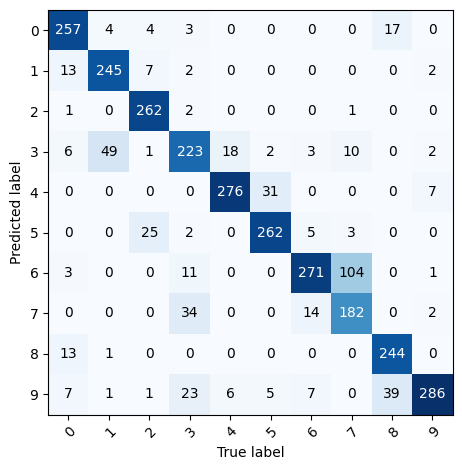

In [ ]:
conf_mat=confusion_matrix(y_test,predictions_single,num_classes)
class_wise_f1=class_wise_f1_score(y_test,predictions_single,num_classes)

print("\n:: Class wise F1 score ::\n")
print(class_wise_f1)

plot(conf_mat,num_classes)

# Three Learners (Including MLP)

In [ ]:
def normalize(X):
    """Normalize the data to have zero mean and unit variance"""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_norm = (X - mean) / std
    return X_norm

In [ ]:
data_set = np.genfromtxt(r"/content/drive/MyDrive/PRNN/A1/PCA_MNIST.csv",delimiter=",",dtype=float,skip_header=1).astype(np.float64)

In [ ]:
X_train=data_set[:int(0.02*(data_set.shape[0])),1:data_set.shape[1]+1]
X_train=normalize(X_train)

y_train=data_set[:int(0.02*(data_set.shape[0])),:1]
y_train=y_train.reshape(-1)

In [ ]:
X_test=data_set[int(0.95*(data_set.shape[0])):,1:data_set.shape[1]+1]
X_test=normalize(X_test)

y_test=data_set[int(0.95*(data_set.shape[0])):,:1]
y_test=y_test.reshape(-1)

In [ ]:
num_classes=int(len(np.unique(y_train)))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1200, 10)
(1200,)
(3000, 10)
(3000,)


In [ ]:
class MLP:
    def __init__(self, W1=None, b1=None, W2=None, b2=None, alpha=None):
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
        self.alpha = alpha
    
    def relu(self, X):
        return np.maximum(0, X)

    def fit(self, X, y, learning_rate=0.01, num_iterations=1000):
        for _ in range(num_iterations):
            # Forward pass
            Z1 = np.dot(X, self.W1) + self.b1
            A1 = self.relu(Z1)
            Z2 = np.dot(A1, self.W2) + self.b2
            A2 = np.sign(Z2)

            # Backward pass
            dZ2 = A2 - y.reshape(-1, 1)
            dW2 = np.dot(A1.T, dZ2)
            db2 = np.sum(dZ2, axis=0, keepdims=True)
            dZ1 = np.dot(dZ2, self.W2.T) * (Z1 > 0)
            dW1 = np.dot(X.T, dZ1)
            db1 = np.sum(dZ1, axis=0, keepdims=True)

            # Update weights and biases
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
    
    def predict(self, X):
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = self.relu(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        return np.sign(Z2).flatten()

In [ ]:
class DecisionStump:
    def __init__(self):
        self.threshold = None
        self.feature = None
        self.polarity = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            true_indices = np.where(X[:, self.feature] < self.threshold)
            predictions[true_indices] = -1
        else:
            false_indices = np.where(X[:, self.feature] >= self.threshold)
            predictions[false_indices] = -1
        return predictions

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y, sample_weight=None):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) if sample_weight is None else np.dot(X.T, sample_weight * (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y) if sample_weight is None else np.sum(sample_weight * (y_predicted - y))

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return np.where(y_predicted > 0.5, 1, -1)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [ ]:
def initialize_weights(input_dim, hidden_dim, output_dim):
    W1 = np.random.randn(input_dim, hidden_dim) * 0.01
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) * 0.01
    b2 = np.zeros((1, output_dim))
    return W1, b1, W2, b2

In [ ]:
def adaboost_multiple(X, y, M, base_learner):
    n_samples, n_features = X.shape
    weights = np.full(n_samples, (1 / n_samples))
    models = []
    alphas = []

    for _ in range(M):
        model = base_learner()
        is_nn = isinstance(model, MLP)
        is_lr = isinstance(model, LogisticRegression)

        if is_nn:
            input_dim = X.shape[1]
            hidden_dim = 4
            output_dim = 1
            W1, b1, W2, b2 = initialize_weights(input_dim, hidden_dim, output_dim)
            model.W1 = W1
            model.b1 = b1
            model.W2 = W2
            model.b2 = b2
            model.fit(X, y)

        elif is_lr:
            model.fit(X, y, sample_weight=weights)
        else:
            # Find the best stump using the weights
            min_error = float('inf')
            for feature in range(n_features):
                for threshold in np.unique(X[:, feature]):
                    for polarity in [1, -1]:
                        model.threshold = threshold
                        model.feature = feature
                        model.polarity = polarity
                        predictions = model.predict(X)
                        error = sum(weights * (y != predictions))

                        if error < min_error:
                            min_error = error
                            best_threshold = threshold
                            best_feature = feature
                            best_polarity = polarity

            # Assign the best values to the model
            model.threshold = best_threshold
            model.feature = best_feature
            model.polarity = best_polarity

        predictions = model.predict(X)
        error = sum(weights * (y != predictions))
        alpha = 0.5 * np.log((1.0 - error) / (error + 1e-10))
        model.alpha = alpha

        # Update the weights
        weights *= np.exp(-alpha * y * predictions)
        weights /= np.sum(weights)

        models.append(model)
        alphas.append(alpha)

    return models, alphas





def adaboost_ova_multiple(X, y, M, base_learners):
    n_classes = len(np.unique(y))
    binary_classifiers = []
    
    for c in range(n_classes):
        binary_y = np.where(y == c, 1, -1)
        
        class_models = []
        class_alphas = []
        for base_learner in base_learners:
            model, alphas = adaboost_multiple(X, binary_y, M, base_learner)
            class_models.extend(model)  
            class_alphas.extend(alphas) 
        binary_classifiers.append((class_models, class_alphas))
    
    return binary_classifiers

def predict_ova_multiple(binary_classifiers, X):
    class_confidences = []
    for class_models_alphas in binary_classifiers:
        class_models = class_models_alphas[0]
        class_alphas = class_models_alphas[1]
        confidences = []
        for i in range(len(class_models)):
            model = class_models[i]
            alpha = class_alphas[i]
            predictions = model.predict(X)
            confidences.append(alpha * predictions)
        class_confidences.append(np.sum(confidences, axis=0))

    return np.argmax(class_confidences, axis=0)

In [ ]:
base_learners = [DecisionStump,LogisticRegression, MLP]
binary_classifiers = adaboost_ova_multiple(X_train, y_train, 50, base_learners)

# Modify the `predict_ova` function to handle multiple base learners

predictions = predict_ova_multiple(binary_classifiers, X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(np.unique(predictions))

Accuracy: 80.30%
[0 1 2 3 4 5 6 7 8 9]



:: Class wise F1 score ::

[0.85343228 0.84285714 0.93497364 0.50319829 0.92283951 0.88324873
 0.69712794 0.57371795 0.8681672  0.9248366 ]


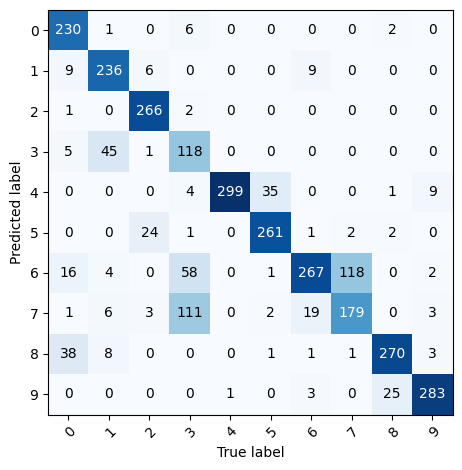

In [ ]:
num_classes=10
conf_mat=confusion_matrix(y_test,predictions,num_classes)
class_wise_f1=class_wise_f1_score(y_test,predictions,num_classes)

print("\n:: Class wise F1 score ::\n")
print(class_wise_f1)

plot(conf_mat,num_classes)

# Question 4: GMM and K-Means Clustering using KMNIST

# Data importing and preprocessing

In [ ]:
arr = np.loadtxt("/content/drive/MyDrive/PRNN/A1/Dig-MNIST.csv",delimiter=",", dtype= str)

In [ ]:
arr_2 = arr[1:,:].astype(np.float64)
print(arr.shape)

(10241, 785)


#Split the feature data

In [ ]:
X = arr_2[:,1:]
X = X.astype('float32') / 255

# Part a: GMM Clustering by defining Class GMM

In [ ]:
class GMM:
    def __init__(self, k, max_iter=100, tol=1e-4, reg_covar=1e-6):
        self.k = k  # number of clusters
        self.max_iter = max_iter  # maximum number of iterations
        self.tol = tol  # tolerance for convergence
        self.reg_covar = reg_covar  # regularization strength for covariance matrices

    def fit(self, X):
        # Initialize the means, covariances, and weights randomly
        self.means = np.random.rand(self.k, X.shape[1])
        self.covs = np.array([np.eye(X.shape[1]) for _ in range(self.k)])
        self.weights = np.ones(self.k) / self.k

        # Initialize prev_ll
        prev_ll = -np.inf
        epsl = 1e-6
        # Iterate until convergence
        for i in range(self.max_iter):
            # Expectation step
            pdfs = np.array([self.pdf(X, self.means[j], self.covs[j]) for j in range(self.k)]).T
            # gamma = (pdfs * self.weights) / np.sum(pdfs * self.weights, axis=1)[:, np.newaxis]
            gamma = (pdfs * self.weights) / (np.sum(pdfs * self.weights, axis=1)[:, np.newaxis] + epsl)
            
            # Maximization step
            Nk = np.sum(gamma, axis=0)
            self.means = np.dot(gamma.T, X) / (Nk[:, np.newaxis] + epsl)
            diff = X[:, np.newaxis, :] - self.means
            covs_temp = np.zeros((self.k, X.shape[1], X.shape[1]))
            for i in range(self.k):
                covs_temp[i] = np.dot((gamma[:, i, np.newaxis] * diff[:, i]).T, diff[:, i]) / (Nk[i] + epsl)
            self.covs = covs_temp
            self.covs += self.reg_covar * np.eye(X.shape[1])[np.newaxis, :, :]
            for j in range(self.k):
                np.fill_diagonal(self.covs[j], np.diag(self.covs[j]))
            self.weights = Nk / X.shape[0]

            # Check for convergence
            if i > 0 and np.abs(self.log_likelihood(X) - prev_ll) < self.tol:
                break
            prev_ll = self.log_likelihood(X)

    def pdf(self, X, mean, cov):
        N = X.shape[1]
        diff = X - mean
        try:
            # Use Cholesky decomposition to compute the log-determinant of the covariance matrix
            L = np.linalg.cholesky(cov + self.reg_covar * np.eye(N))
            log_det = 2 * np.sum(np.log(np.diag(L)))
            # Use the log-determinant to compute the log-likelihood of the data under the Gaussian mixture model
            log_likelihood = -0.5 * (log_det + np.sum(diff.dot(np.linalg.solve(L.T, np.linalg.solve(L, diff.T))), axis=0))
        except:
            # If Cholesky decomposition fails, use the pseudo-inverse to compute the log-likelihood
            cov_inv = np.linalg.pinv(cov + self.reg_covar * np.eye(N))
            log_det = np.log(np.linalg.det(cov + self.reg_covar * np.eye(N)))
            log_likelihood = -0.5 * (log_det + np.sum(diff.dot(cov_inv) * diff, axis=1))
        return np.exp(log_likelihood)

    def log_likelihood(self, X):
        pdfs = np.array([self.pdf(X, self.means[j], self.covs[j]) for j in range(self.k)]).T
        return np.sum(np.log(np.sum(pdfs * self.weights[np.newaxis, :], axis=1) + 1e-8))


In [ ]:
print(X.shape)

(10240, 784)


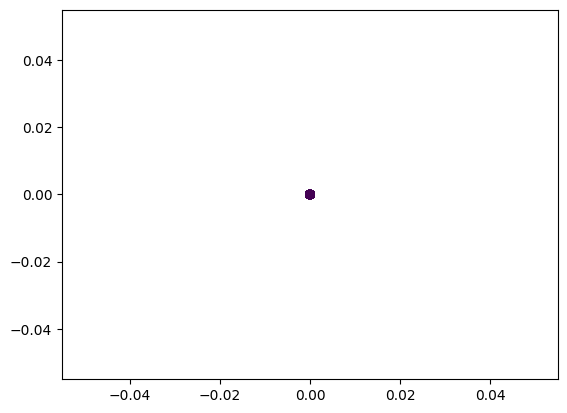

In [ ]:
# Initialize the GMM model with k=10 and regularization strength=1e-6
gmm = GMM(k=10, reg_covar=1e-6)

# Fit the GMM model to the MNIST dataset
gmm.fit(X)

# Predict the cluster assignments for each data point
y_pred = np.argmax(np.array([gmm.pdf(X, gmm.means[j], gmm.covs[j]) * gmm.weights[j] for j in range(gmm.k)]).T, axis=1)

# Plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

The scatter plot visualizes the cluster assignments of the data points from the K-MNIST dataset. However, since the K-MNIST dataset is high-dimensional (784 dimensions for each image), directly plotting X[:, 0] and X[:, 1] won't provide meaningful visualization.

Instead, Use t-SNE to reduce the dimensionality of the dataset to 2D or 3D.

# Part b: K-means Clustering by defining K-means

In [ ]:
class KMeans:
    def __init__(self, k, max_iter=100, tol=1e-4):
        self.k = k  # number of clusters
        self.max_iter = max_iter  # maximum number of iterations
        self.tol = tol  # tolerance for convergence

    def fit(self, X):
        # Initialize the cluster centers randomly
        idx = np.random.choice(X.shape[0], self.k, replace=False)
        self.centers = X[idx]

        # Iterate until convergence
        for i in range(self.max_iter):
            # Compute the distances between each data point and the cluster centers
            dists = np.sqrt(np.sum((X[:, np.newaxis, :] - self.centers) ** 2, axis=2))

            # Assign each data point to the closest cluster center
            labels = np.argmin(dists, axis=1)

            # Update the cluster centers to be the mean of the assigned data points
            new_centers = np.array([X[labels == j].mean(axis=0) for j in range(self.k)])

            # Check for convergence
            if i > 0 and np.linalg.norm(new_centers - self.centers) < self.tol:
                break
            self.centers = new_centers

    def predict(self, X):
        # Compute the distances between each data point and the cluster centers
        dists = np.sqrt(np.sum((X[:, np.newaxis, :] - self.centers) ** 2, axis=2))

        # Assign each data point to the closest cluster center
        labels = np.argmin(dists, axis=1)
        return labels

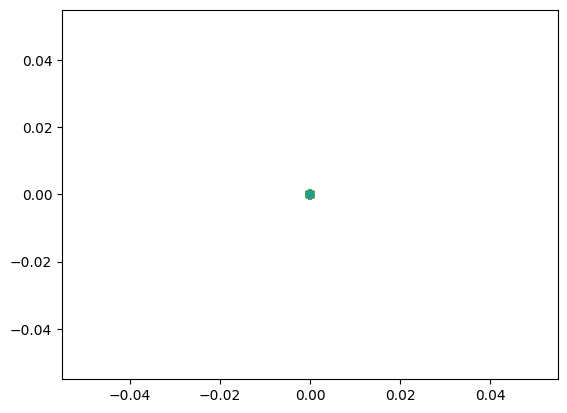

In [ ]:
# Initialize the KMeans model
kmeans = KMeans(k=10)

# Fit the KMeans model to the KMNIST dataset
kmeans.fit(X)

# Predict the cluster assignments for each data point
y_pred_kmeans = kmeans.predict(X)

# Plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=y_pred_kmeans)
plt.show()

# NMI scores for both GMM-based clustering and K-means clustering

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

# Load the true labels from the CSV file
y_true = arr_2[:, 0].astype(int)

# Compute the NMI between the true labels and the predicted labels for GMM-based clustering
nmi_gmm = normalized_mutual_info_score(y_true, y_pred)

# Compute the NMI between the true labels and the predicted labels for K-means clustering
nmi_kmeans = normalized_mutual_info_score(y_true, y_pred_kmeans)

print(f"NMI for GMM-based clustering: {nmi_gmm:.4f}")
print(f"NMI for K-means clustering: {nmi_kmeans:.4f}")

NMI for GMM-based clustering: 0.0000
NMI for K-means clustering: 0.5190


t-SNE embeddings and the cluster assignments for different number of clusters for both GMM-based clustering and K-means clustering

In [ ]:
from sklearn.manifold import TSNE

# Define a function to compute the t-SNE embedding and plot the cluster assignments
def plot_tsne(X, y_true, y_pred, title):
    # Compute the t-SNE embedding
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Plot the t-SNE embedding and the cluster assignments
    plt.figure(figsize=(8, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_true, alpha=0.5, cmap='tab10')
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred, alpha=0.5, cmap='tab10')
    plt.title(title)
    plt.show()

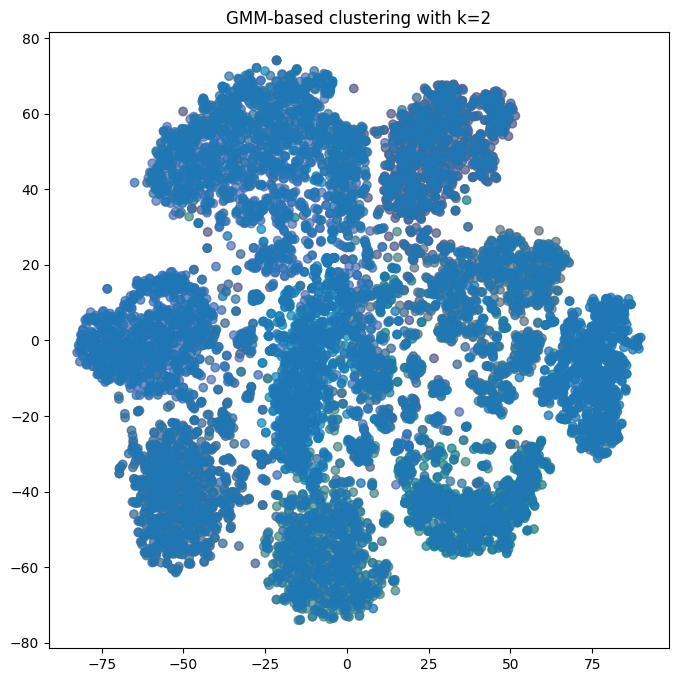

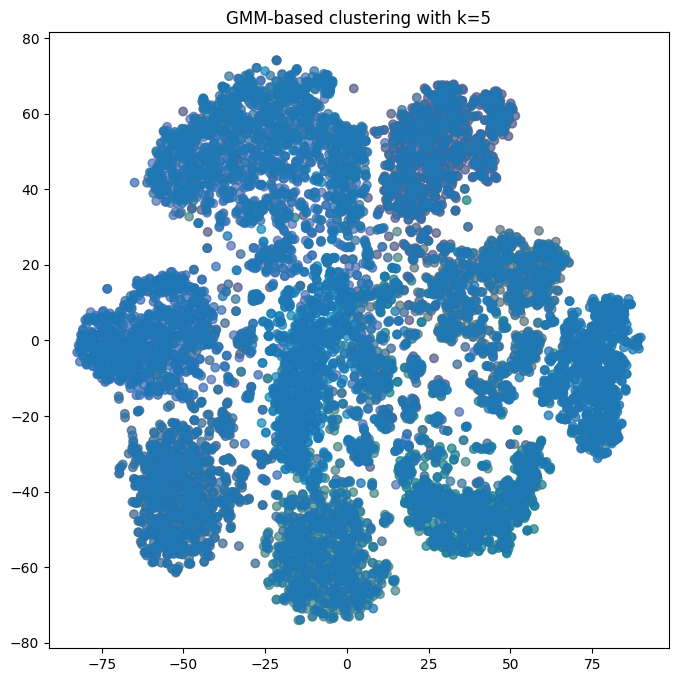

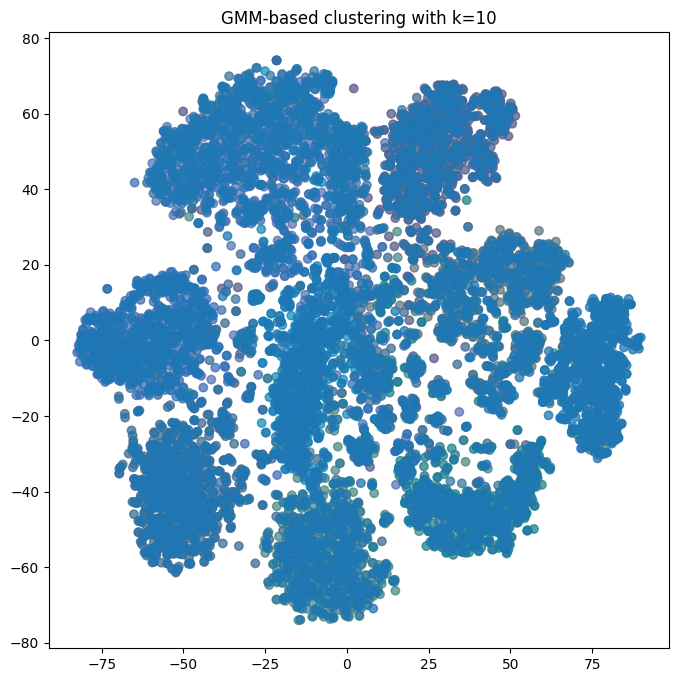

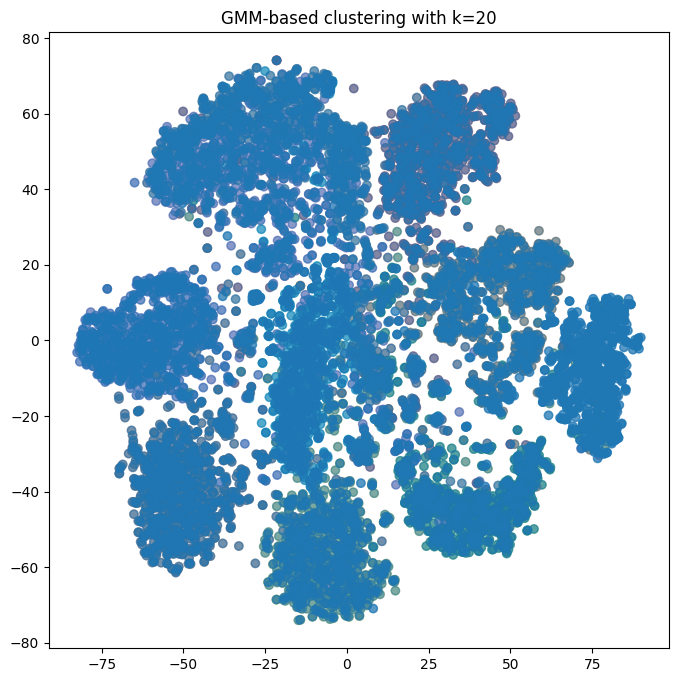

In [ ]:
for k in [2, 5, 10, 20]:
    # GMM-based clustering
    gmm = GMM(k=k)
    gmm.fit(X)
    y_pred_gmm = np.argmax(np.array([gmm.pdf(X, gmm.means[j], gmm.covs[j]) * gmm.weights[j] for j in range(gmm.k)]).T, axis=1)
    plot_tsne(X, y_true, y_pred_gmm, f"GMM-based clustering with k={k}")

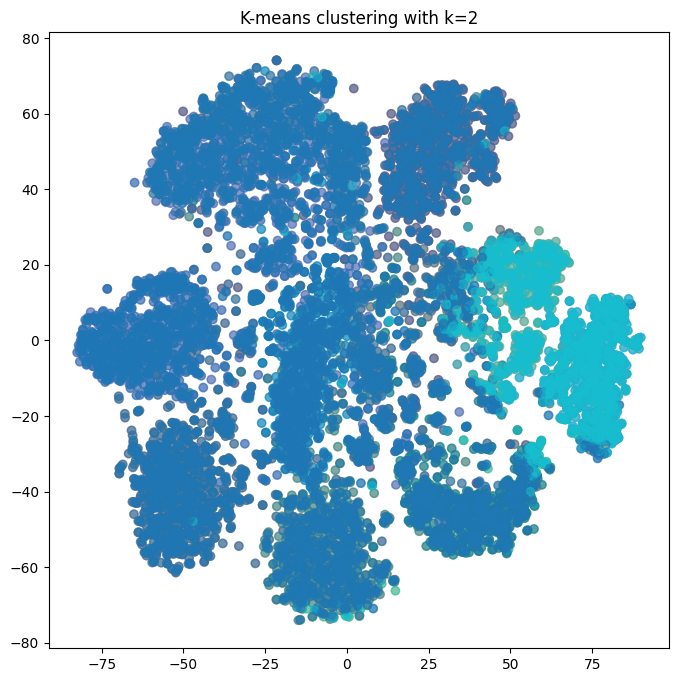

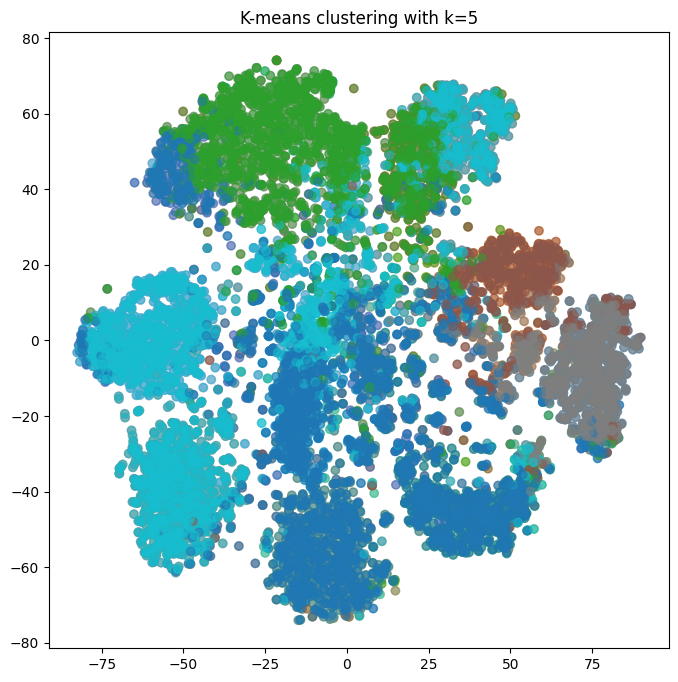

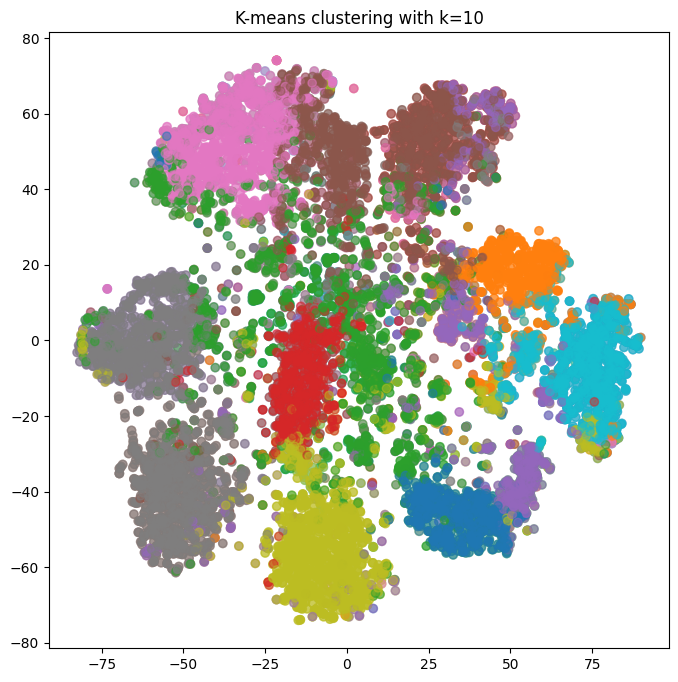

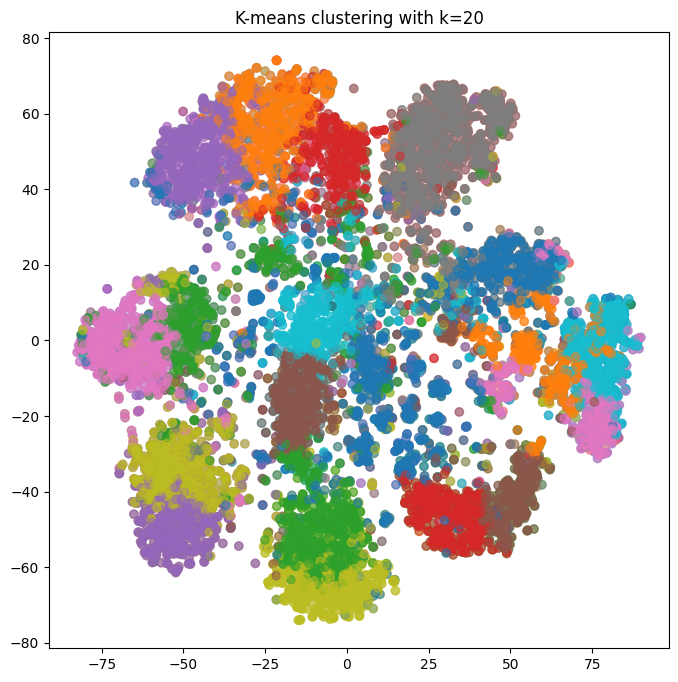

In [ ]:
# Experiment with different number of clusters and plot the t-SNE plots for all cases
for k in [2, 5, 10, 20]:
    # K-means clustering
    kmeans = KMeans(k=k)
    kmeans.fit(X)
    y_pred_kmeans = kmeans.predict(X)
    plot_tsne(X, y_true, y_pred_kmeans, f"K-means clustering with k={k}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Load the KMNIST dataset from the CSV file
data = np.genfromtxt('p4.csv', delimiter=',', skip_header=1)

# Split the data into features and labels
X = data[:, 1:]
y = data[:, 0]

mean = np.mean(X, axis=0)
X_centered = X - mean


# Compute the covariance matrix
cov_matrix = np.cov(X_centeres.T)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sort_indices]
eigenvectors = eigenvectors[:,sort_indices]


In [ ]:
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

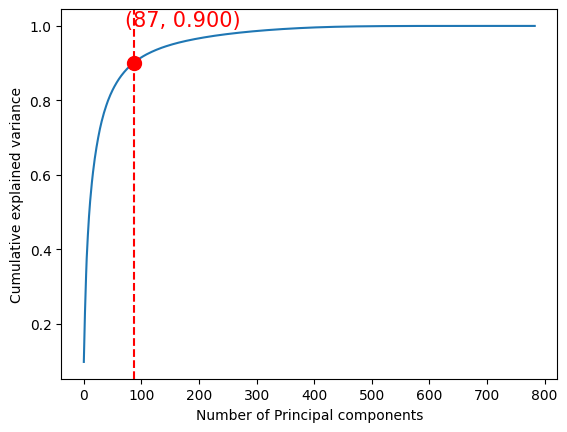

In [ ]:
pca = PCA(n_components = 100)
X_train_embed = pca.fit_transform(xtrain)

eigenvalues = pca.eigen_val.reshape(-1,784)

# Compute the explained variance ratio
total_var = np.sum(eigenvalues)
var_ratio = eigenvalues / total_var

# Compute the cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(var_ratio)

# Plot the variance ratio as a function of the number of components
plt.plot(cumulative_var_ratio)
plt.xlabel('Number of Principal components')
plt.ylabel('Cumulative explained variance')

# Find the index of the first element in cumulative_var_ratio that is greater than 0.8
n_components_80 = np.argmax(cumulative_var_ratio > 0.9) + 1

# Find the x and y coordinates of the intersection point
x_intersect = n_components_80
y_intersect = cumulative_var_ratio[n_components_80 - 1]

# Add a vertical line to the plot to highlight the number of components required for 80% variance
plt.axvline(x=n_components_80, color='r', linestyle='--')

# Add a marker at the intersection point
plt.plot(x_intersect, y_intersect, marker='o', markersize=10, color='r')

# Show the x and y coordinates of the intersection point
plt.annotate(f'({x_intersect}, {y_intersect.real:.3f})', xy=(x_intersect, y_intersect), 
             xytext=(x_intersect-15, y_intersect+0.1), color='r', fontsize=15)

# Show the plot
plt.show()